### **Project Setup and Library Imports**  


---


*   In this step, we prepare the environment by importing all the necessary libraries.  
*   These include tools for handling files and images, building and training deep learning models, and evaluating their performance.  
*   We also bring in visualization libraries to help us better understand the data and the results.  


---


This setup ensures that everything we need for data processing, model development, and evaluation is ready before we start building the CNN Autoencoder with U-Net skip connections.


---

*Note: We didn't used "`roc_auc_score`", was just using it for experimental stuff*

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
# import plotly.express as px
import hashlib
import re
import cv2
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_fscore_support, auc
from sklearn.preprocessing import label_binarize
# from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.image import resize, ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from collections import Counter
from google.colab import drive, files
from pathlib import Path
from PIL import Image, ImageStat, UnidentifiedImageError, ImageEnhance
from matplotlib import patches
from tqdm import tqdm

print(tf.__version__)

2.19.0


### **Accessing the Dataset**  


---


* Here we mount Google Drive and extract the dataset from a zip file into Colab’s local storage so it’s ready to use.

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/CroppedYale.zip'
extract_to = '/content/my_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Mounted at /content/drive


### **Converting PGM Images to JPG**  


---


* The CroppedYale dataset provides images in PGM format, which is less commonly used and may not be supported by some deep learning tools.  
* In this step, we build a conversion pipeline that processes all PGM files, converts them into JPG format, and saves them in a new directory while keeping the original folder structure.  


---


* The code also verifies the conversion by checking that all files in the new directory are JPG images.  
* This ensures that the dataset is clean, consistent, and ready for EDA, data cleaning, data preprocessing, and model training.

In [ ]:
converted_dir = '/content/my_data_jpg' # Directory to save converted images

os.makedirs(converted_dir, exist_ok = True)

def convert_pgm_to_jpg(pgm_path, jpg_path):
    try:
        with Image.open(pgm_path) as img:
            img.convert('RGB').save(jpg_path, 'JPEG')
        return True
    except Exception as e:
        print(f"Error converting {pgm_path}: {e}")
        return False

print(f"Extracting images from {zip_path} to {extract_to}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("Extraction complete.")

failed_files = []
converted_count = 0

print(f"Converting PGM images in {extract_to} to JPG in {converted_dir}...")

for root, _, files in os.walk(extract_to):
    for file in files:
        if file.lower().endswith(('.pgm', '.pgm.bad')): # Found some images with ".pgm.bad"
            pgm_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, extract_to)
            output_dir = os.path.join(converted_dir, relative_path)
            os.makedirs(output_dir, exist_ok = True)

            jpg_filename = os.path.splitext(file)[0] + '.jpg'
            jpg_path = os.path.join(output_dir, jpg_filename)

            if convert_pgm_to_jpg(pgm_path, jpg_path):
                converted_count += 1
            else:
                failed_files.append(pgm_path)

print(f"\nConversion process finished.")
print(f"Successfully converted {converted_count} images.")

if failed_files:
    print(f"Failed to convert {len(failed_files)} files.")
    print("List of failed files:")
    for f in failed_files:
        print(f)

print("\nVerifying image formats in the converted directory...")

jpg_count = 0
other_count = 0
for root, _, files in os.walk(converted_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if file.lower().endswith('.jpg') or file.lower().endswith('.jpeg'):
            jpg_count += 1
        else:
            other_count += 1

print(f"Found {jpg_count} JPG images in the converted directory.")
print(f"Found {other_count} other files in the converted directory.")

if other_count == 0 and jpg_count > 0:
    print("Verification successful: All images in the converted directory are in JPG format.")
elif jpg_count > 0:
    print("Verification warning: Found non-JPG files in the converted directory.")
else:
    print("Verification failed: No JPG images found in the converted directory.")

Extracting images from /content/drive/MyDrive/CroppedYale.zip to /content/my_data...
Extraction complete.
Converting PGM images in /content/my_data to JPG in /content/my_data_jpg...

Conversion process finished.
Successfully converted 2470 images.

Verifying image formats in the converted directory...
Found 2470 JPG images in the converted directory.
Found 0 other files in the converted directory.
Verification successful: All images in the converted directory are in JPG format.


# **EDA PROCESS**

### **Building a DataFrame of Images**  


---


* Once the images are converted to JPG, the next step is to organize them into a structured format.  
* Here we scan the converted dataset, collect each image’s class label (taken from the folder name), file name, and full path, and store this information in a Pandas DataFrame.  


---


This makes the dataset easier to explore, analyze, and split later for training and testing.


---

Note: This is a tuble `(path.parts[-2], path.name, str(path)`
which means can contain different datatypes:
* The "`path.parts[-2]`" is the class
* The "`path.name`" is the image or the file itself
* The `"str(path)"` is the full path of files

In [ ]:
image_extensions = {'.jpg', '.jpeg', '.png'}
paths = [(path.parts[-2], path.name, str(path)) for path in Path(converted_dir).rglob('*.*') if path.suffix.lower() in image_extensions]

df = pd.DataFrame(paths, columns = ['class', 'image', 'full_path'])
df = df.sort_values('class', ascending = True)
df.reset_index(drop = True, inplace = True)
df

class                     image  \
0     yaleB01  yaleB01_P00A-110E+15.jpg   
1     yaleB01  yaleB01_P00A-015E+20.jpg   
2     yaleB01  yaleB01_P00A-025E+00.jpg   
3     yaleB01  yaleB01_P00A-110E+65.jpg   
4     yaleB01  yaleB01_P00A+035E+15.jpg   
...       ...                       ...   
2465  yaleB39  yaleB39_P00A+060E-20.jpg   
2466  yaleB39  yaleB39_P00A+070E+45.jpg   
2467  yaleB39  yaleB39_P00A+005E-10.jpg   
2468  yaleB39  yaleB39_P00A-020E-10.jpg   
2469  yaleB39  yaleB39_P00A-060E-20.jpg   

                                              full_path  
0     /content/my_data_jpg/CroppedYale/yaleB01/yaleB...  
1     /content/my_data_jpg/CroppedYale/yaleB01/yaleB...  
2     /content/my_data_jpg/CroppedYale/yaleB01/yaleB...  
3     /content/my_data_jpg/CroppedYale/yaleB01/yaleB...  
4     /content/my_data_jpg/CroppedYale/yaleB01/yaleB...  
...                                                 ...  
2465  /content/my_data_jpg/CroppedYale/yaleB39/yaleB...  
2466  /content/my_data_jpg/CroppedYale/yaleB39/yaleB...  
2467  /content/my_data_jpg/CroppedYale/yaleB39/yaleB...  
2468  /content/my_data_jpg/CroppedYale/yaleB39/yaleB...  
2469  /content/my_data_jpg/CroppedYale/yaleB39/yaleB...  

[2470 rows x 3 columns]

### **Dataset Statistics (Count class numbers and dataset size per class)**


---


* To better understand the dataset, we count how many images belong to each class.  
* This also gives us the total number of images and the number of unique classes.  
* Such information is useful to check whether the dataset is balanced and large enough for training.


---
`.items():` "Is used in for loop to iterate over key-value pairs in a dictionary."


In [ ]:
class_count = df['class'].value_counts()
for cls, count in class_count.items():
    print(f'Class: {cls}, Count: {count} images')

print(f"\nTotal dataset size is: {len(df)} images")
print(f"Number of classes: {df['class'].nunique()} classes")

Class: yaleB01, Count: 65 images
Class: yaleB02, Count: 65 images
Class: yaleB03, Count: 65 images
Class: yaleB04, Count: 65 images
Class: yaleB05, Count: 65 images
Class: yaleB06, Count: 65 images
Class: yaleB07, Count: 65 images
Class: yaleB08, Count: 65 images
Class: yaleB09, Count: 65 images
Class: yaleB10, Count: 65 images
Class: yaleB11, Count: 65 images
Class: yaleB12, Count: 65 images
Class: yaleB13, Count: 65 images
Class: yaleB15, Count: 65 images
Class: yaleB16, Count: 65 images
Class: yaleB17, Count: 65 images
Class: yaleB18, Count: 65 images
Class: yaleB19, Count: 65 images
Class: yaleB20, Count: 65 images
Class: yaleB21, Count: 65 images
Class: yaleB22, Count: 65 images
Class: yaleB23, Count: 65 images
Class: yaleB24, Count: 65 images
Class: yaleB25, Count: 65 images
Class: yaleB26, Count: 65 images
Class: yaleB27, Count: 65 images
Class: yaleB28, Count: 65 images
Class: yaleB29, Count: 65 images
Class: yaleB30, Count: 65 images
Class: yaleB31, Count: 65 images
Class: yal

### **Visualizing Class Distribution**  


---


* After counting the number of images per class, it is useful to visualize the dataset distribution.  
* Here we use a bar chart to show the absolute count of images per class, and pie chart to highlight the percentage contribution of each class.  
* These visualizations make it easier to spot imbalances in the dataset, which could affect training if some classes are underrepresented.


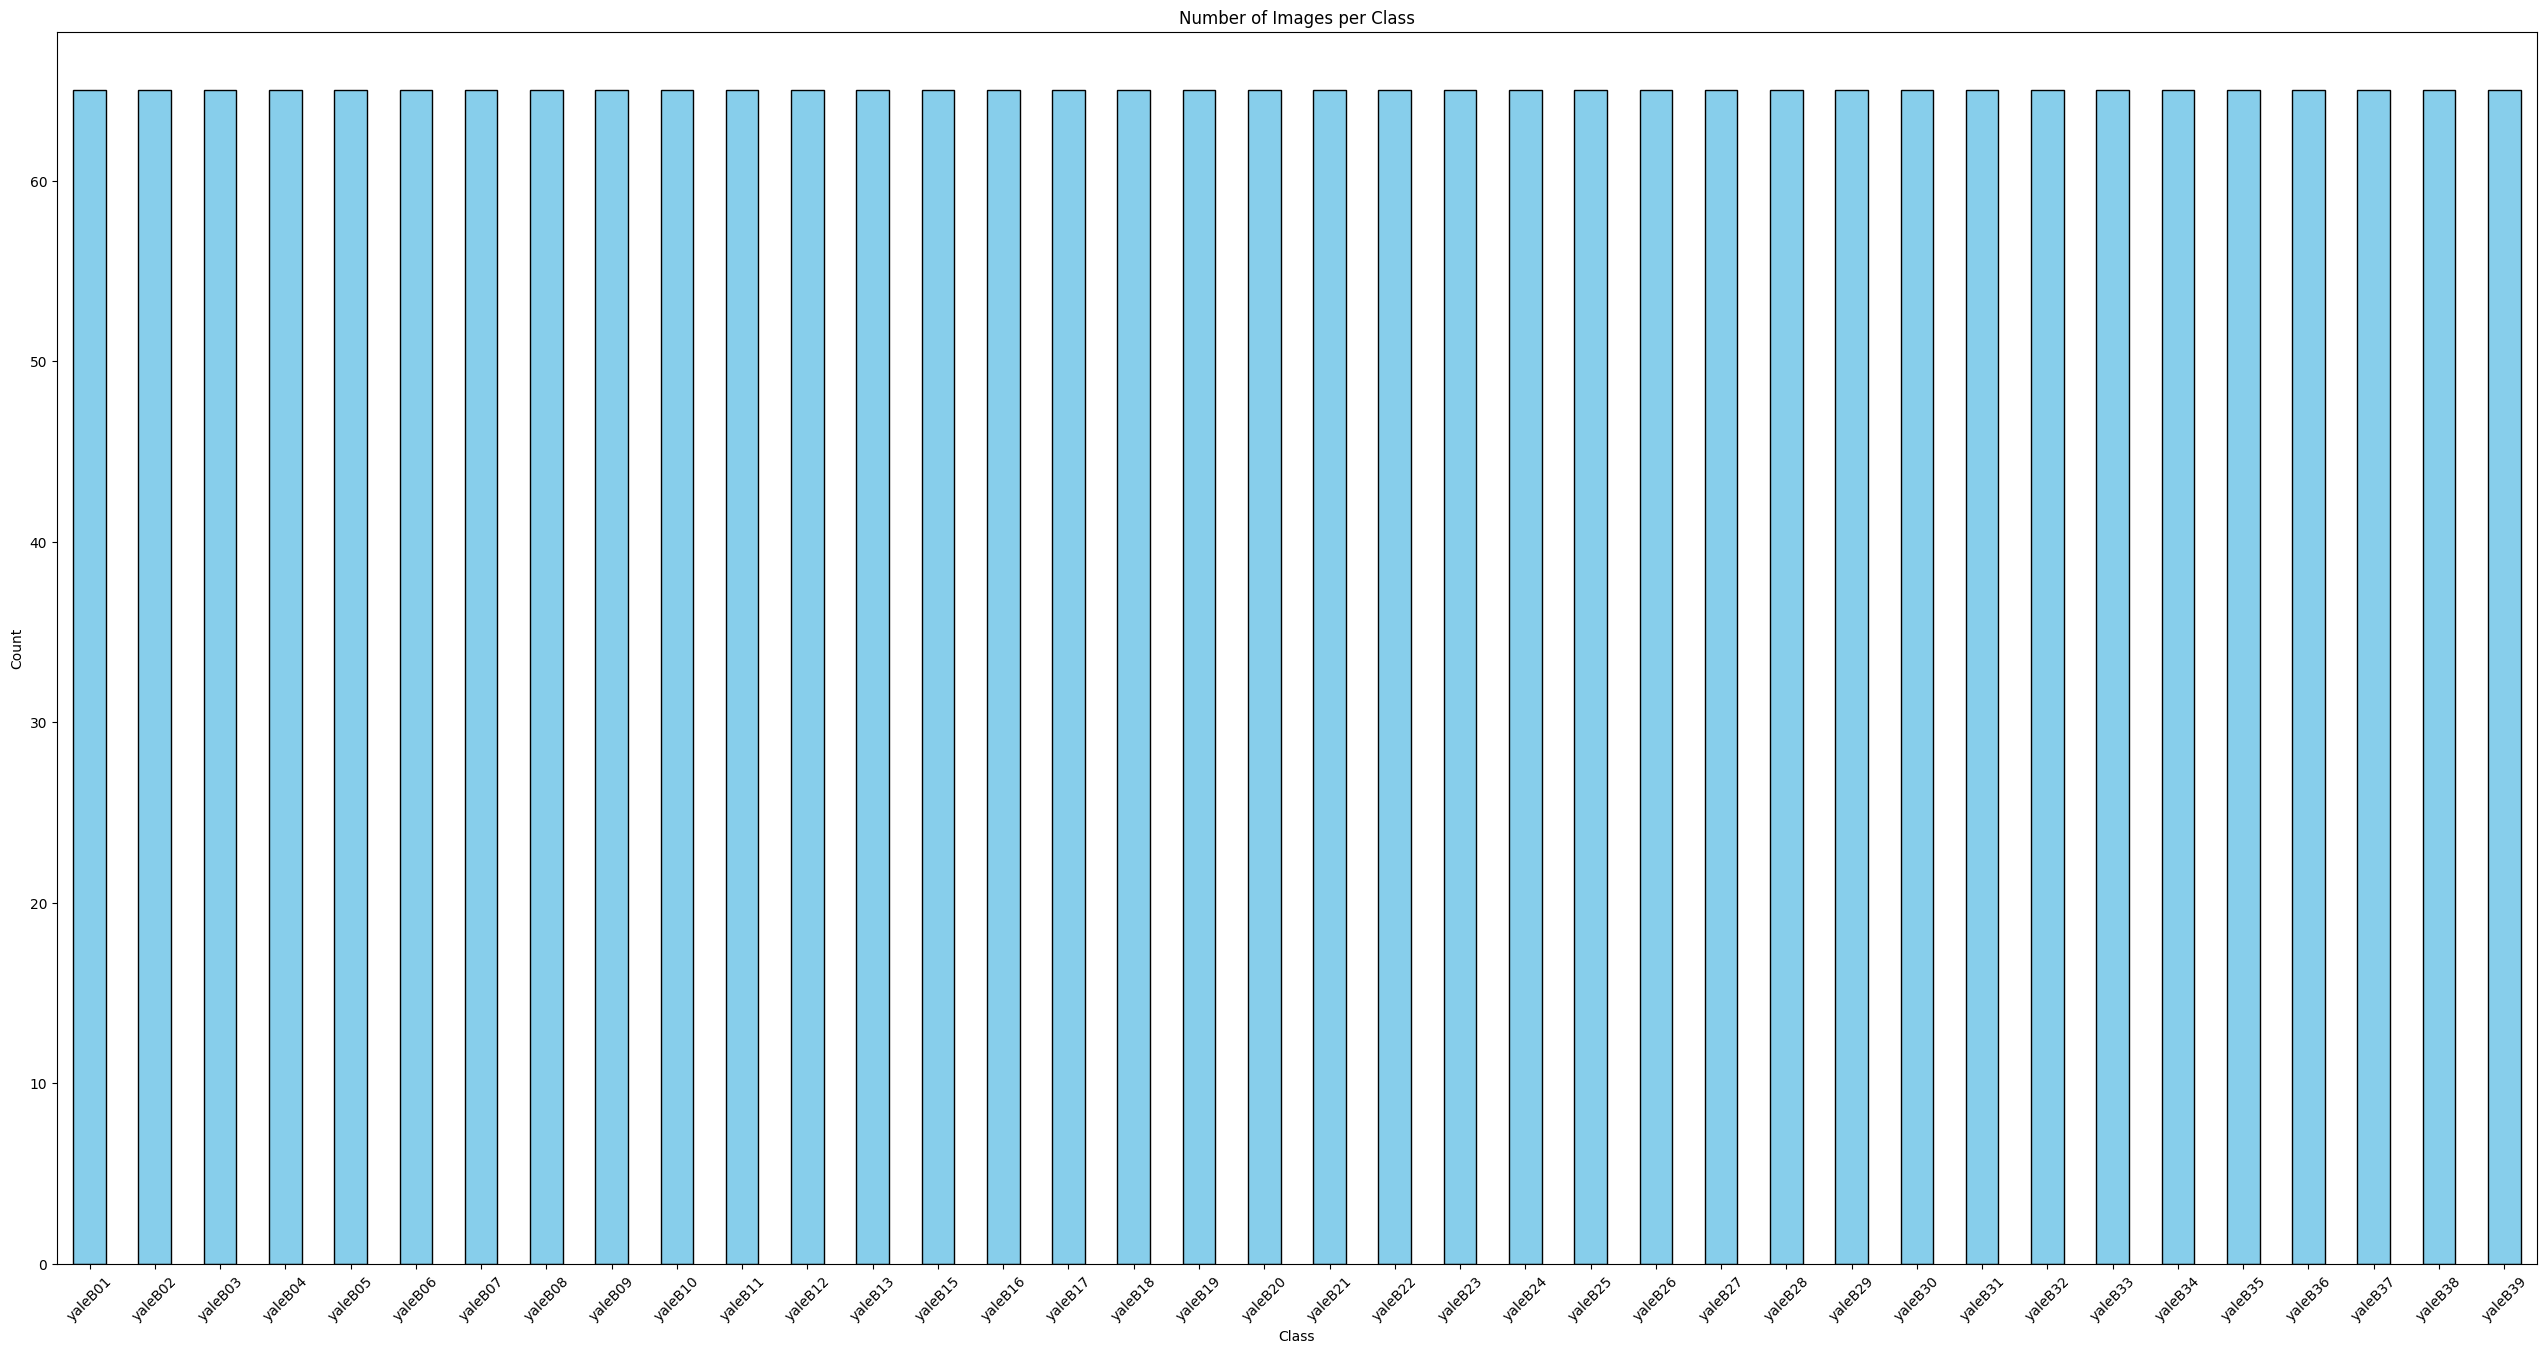

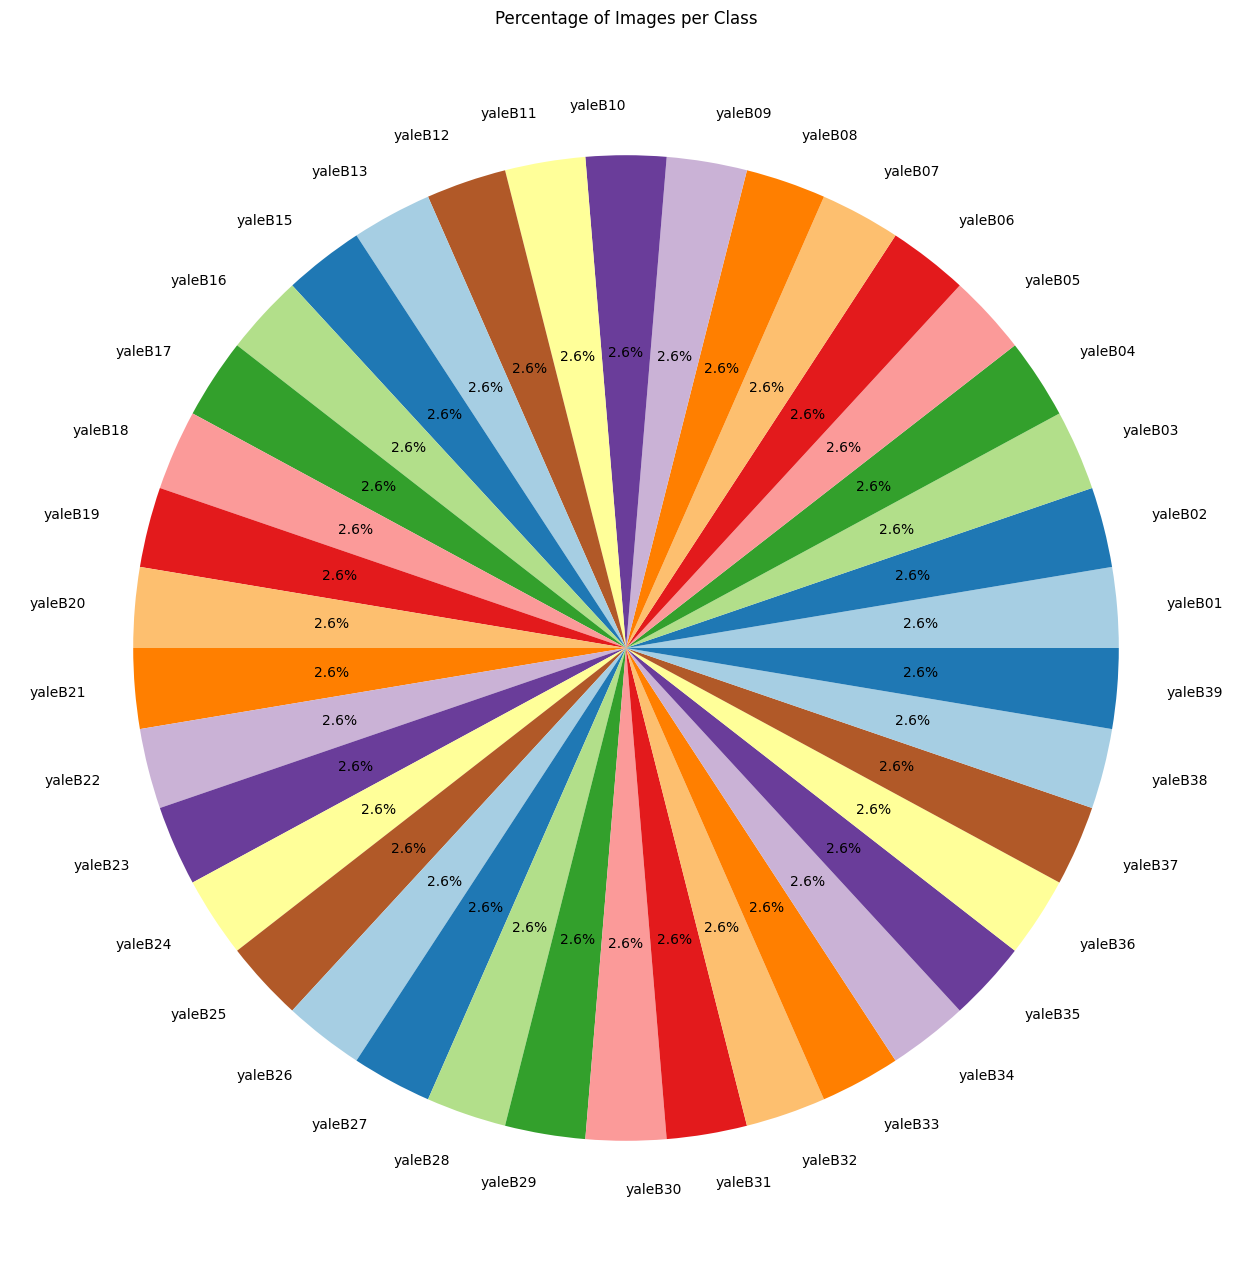

In [ ]:
plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'skyblue', edgecolor = 'black')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'pie', autopct = '%1.1f%%', colors = plt.cm.Paired.colors)
plt.title('Percentage of Images per Class')
plt.ylabel('')
plt.show()

### **Checking Dataset Balance**  


---


* To ensure fair training, it is important to check whether the dataset is balanced across classes.  
* Here we calculate the percentage of images for each class and display both counts and percentages in a summary table.  
* We also plot a bar chart with a red dashed line showing the average class size, which makes it easy to identify classes with more or fewer samples than the average.


---
*Note: Here, we are plotting the average, which means if any class is above or below the average, it indicates class imbalance. However, as we can see in the plot, all classes are consistently around the average.*


         Count  Percentage %
class                       
yaleB01     65          2.63
yaleB02     65          2.63
yaleB03     65          2.63
yaleB04     65          2.63
yaleB05     65          2.63
yaleB06     65          2.63
yaleB07     65          2.63
yaleB08     65          2.63
yaleB09     65          2.63
yaleB10     65          2.63
yaleB11     65          2.63
yaleB12     65          2.63
yaleB13     65          2.63
yaleB15     65          2.63
yaleB16     65          2.63
yaleB17     65          2.63
yaleB18     65          2.63
yaleB19     65          2.63
yaleB20     65          2.63
yaleB21     65          2.63
yaleB22     65          2.63
yaleB23     65          2.63
yaleB24     65          2.63
yaleB25     65          2.63
yaleB26     65          2.63
yaleB27     65          2.63
yaleB28     65          2.63
yaleB29     65          2.63
yaleB30     65          2.63
yaleB31     65          2.63
yaleB32     65          2.63
yaleB33     65          2.63
yaleB34     65

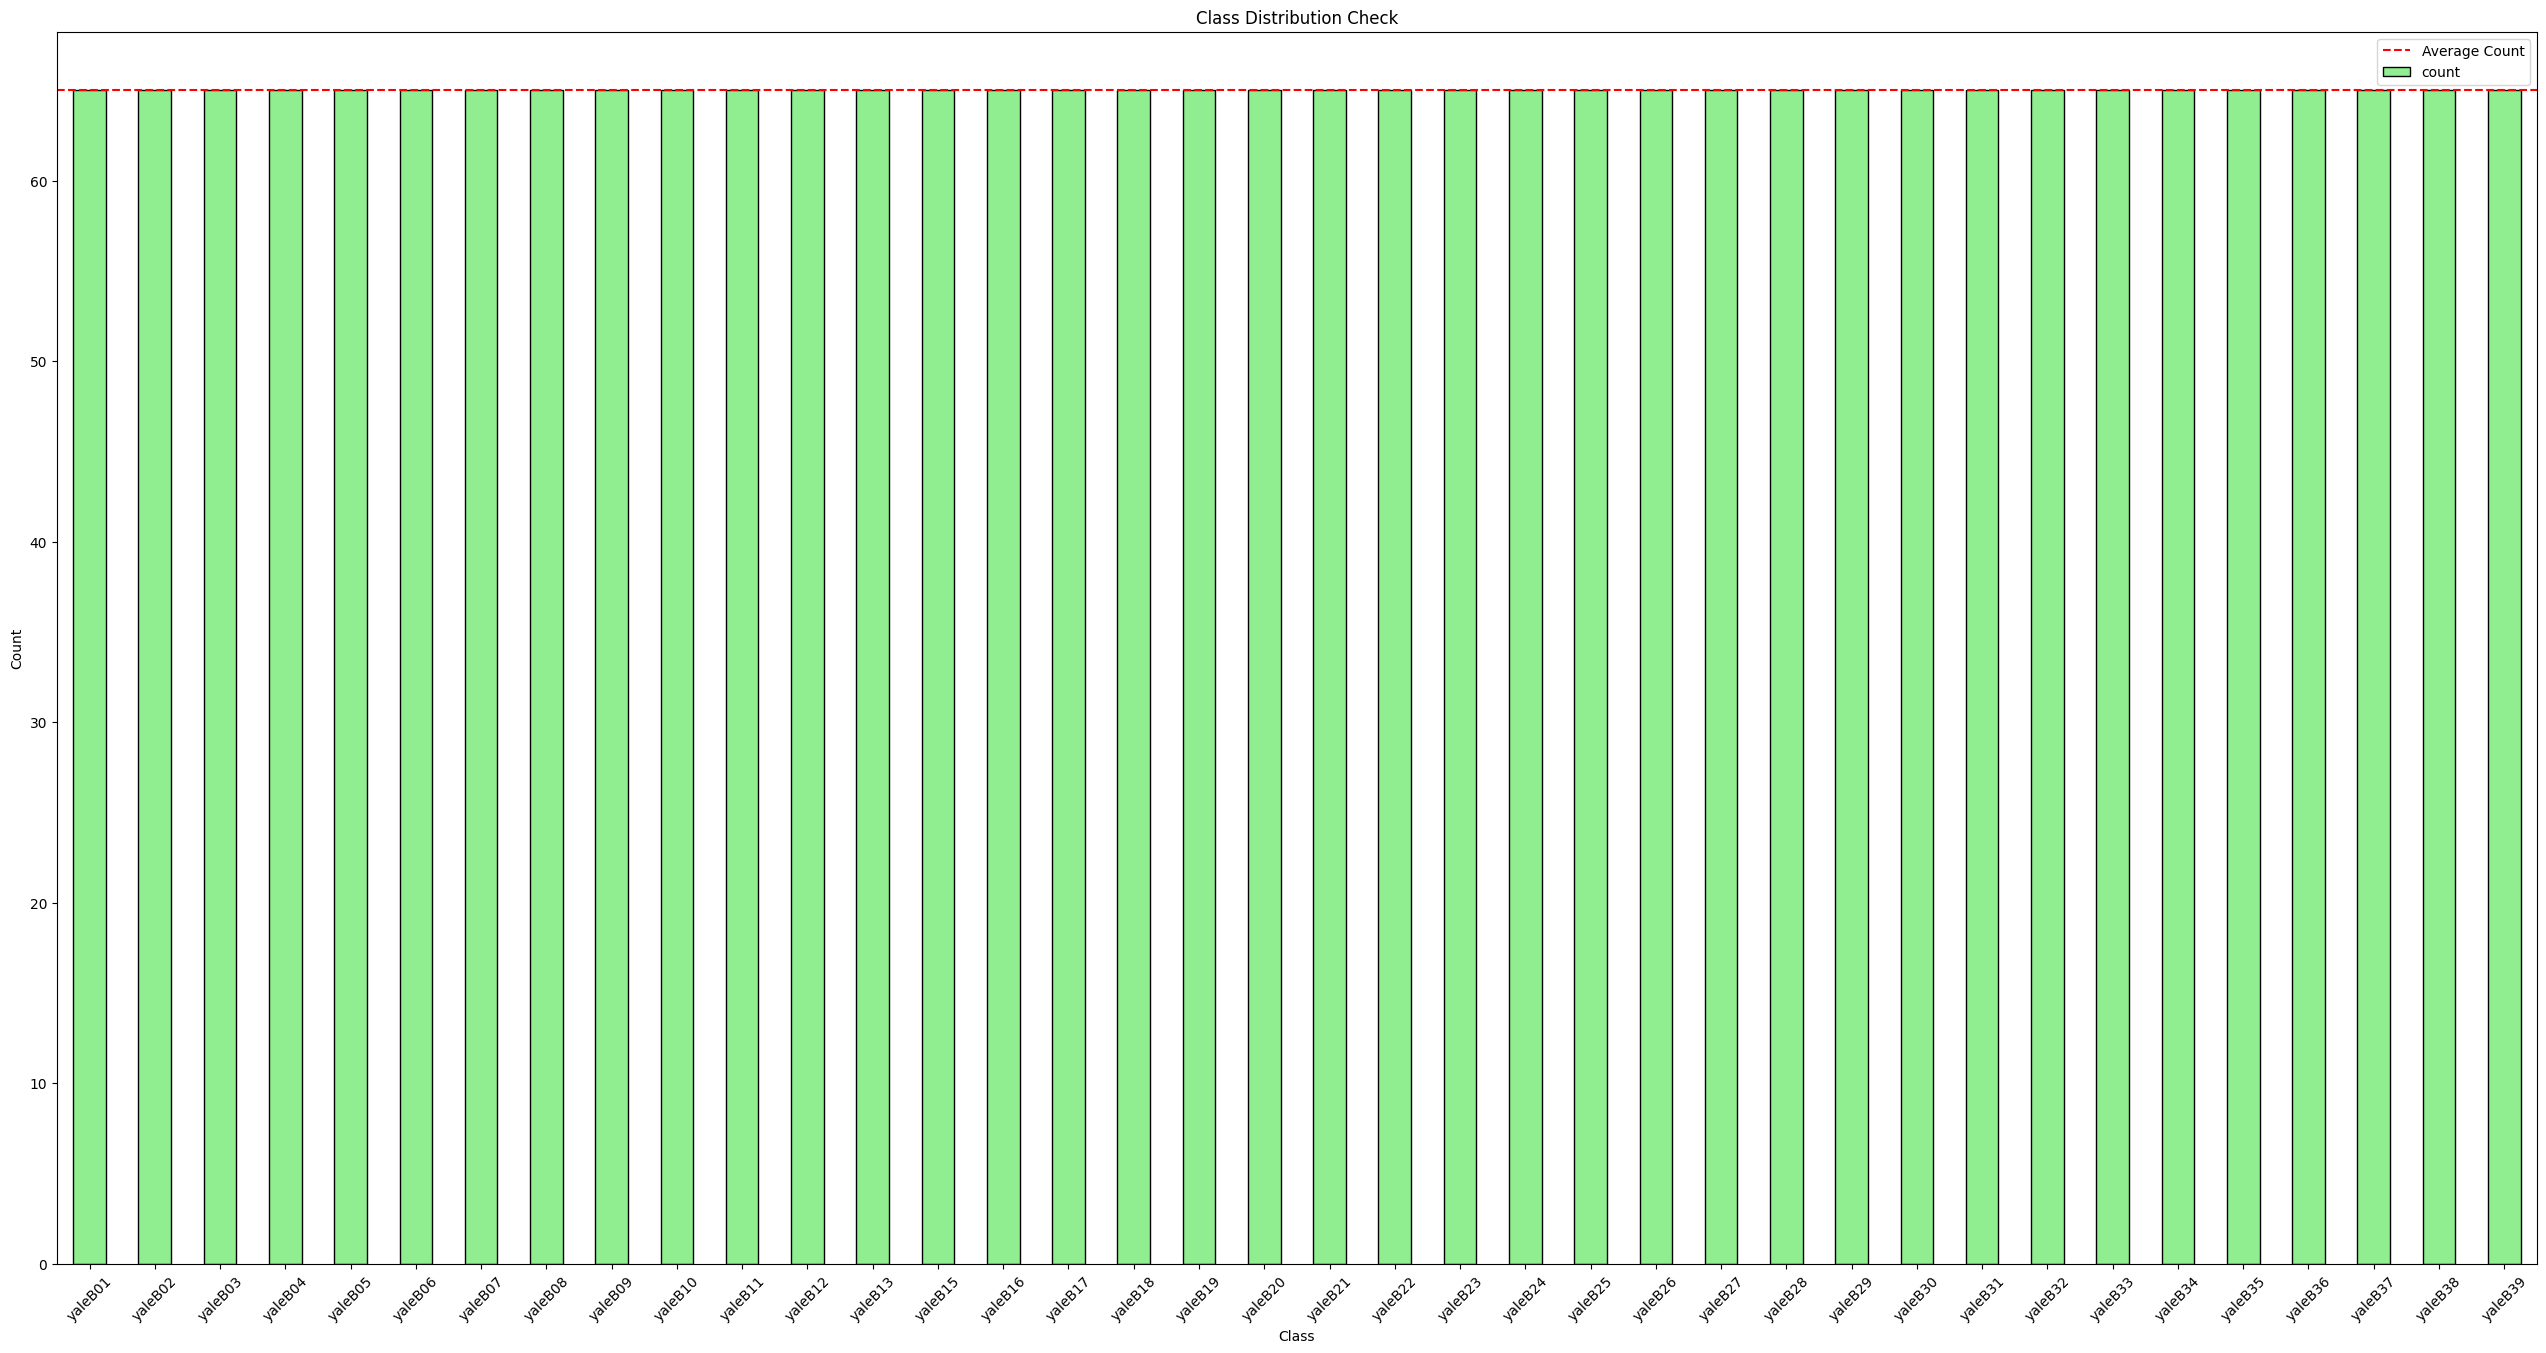

In [ ]:
percentages = (class_count / len(df)) * 100
imbalance_df = pd.DataFrame({'Count': class_count, 'Percentage %': percentages.round(2)})
print(imbalance_df)

plt.figure(figsize = (32, 16))
class_count.plot(kind = 'bar', color = 'lightgreen', edgecolor = 'black')
plt.title('Class Distribution Check')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.axhline(y = class_count.mean(), color = 'red', linestyle = '--', label = 'Average Count')
plt.legend()
plt.show()

### **Checking Image Sizes to ensure consistency**  


---


* Before training a CNN, it is important to verify whether all images in the dataset share the same dimensions.  
* Here we collect the width and height of each image, visualize their distributions, and print the unique size values.  
* This ensures consistency in the dataset and helps decide whether resizing is needed before feeding the images into the model.


---

*As we can see in the plot below, there are many dots, which indicates that the images are inconsistent in size. This means we will need to resize them later.*


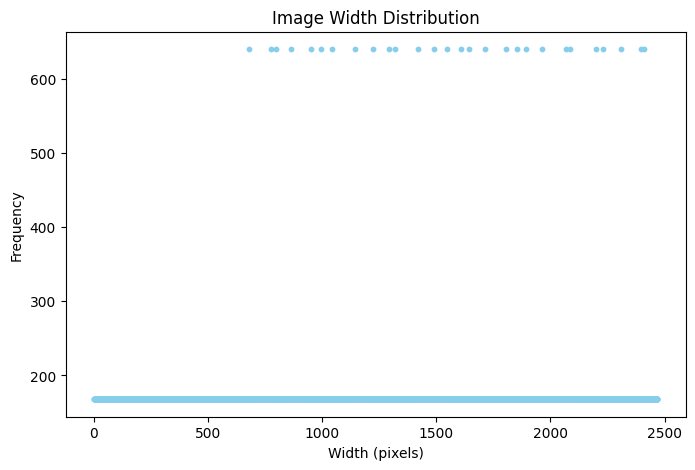

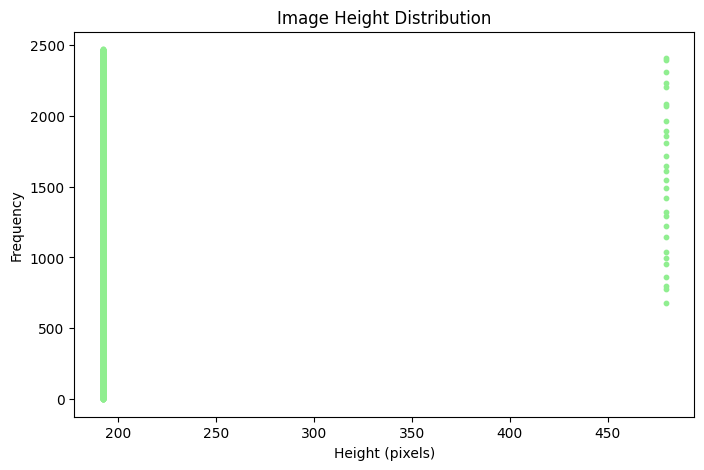

   Width  Height  Count
0    168     192   2442
1    640     480     28


In [ ]:
image_sizes = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

#Width
plt.figure(figsize=(8,5))
plt.scatter(x = range(len(sizes_df)), y = sizes_df['Width'], color='skyblue', s=10)
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

#Height
plt.figure(figsize=(8,5))
plt.scatter(x = sizes_df['Height'], y = range(len(sizes_df)), color='lightgreen', s=10)
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

#For best sure the size of the whole images
unique_sizes = sizes_df.value_counts().reset_index(name='Count')
print(unique_sizes)

### **Visualizing Sample Images with Basic Statistics**  


---


* To better understand the dataset, we randomly select 10 sample images and display them along with basic statistics.  
* For each image, we measure its size, brightness (average pixel intensity), and contrast (pixel intensity variation).  
* This quick check helps verify the dataset’s quality and detect any unusual images, such as those that are too dark, too bright, or corrupted.


Image: yaleB18_P00A-050E-40.jpg | Class: yaleB18 | Size: 168x192 | Brightness: 53.0 | Contrast: 47.8
Image: yaleB35_P00A+095E+00.jpg | Class: yaleB35 | Size: 168x192 | Brightness: 0.1 | Contrast: 0.4
Image: yaleB28_P00A-110E+65.jpg | Class: yaleB28 | Size: 168x192 | Brightness: 7.7 | Contrast: 18.0
Image: yaleB25_P00A-070E-35.jpg | Class: yaleB25 | Size: 168x192 | Brightness: 57.0 | Contrast: 60.4
Image: yaleB06_P00A+070E-35.jpg | Class: yaleB06 | Size: 168x192 | Brightness: 59.2 | Contrast: 60.0
Image: yaleB17_P00A+010E-20.jpg | Class: yaleB17 | Size: 168x192 | Brightness: 100.3 | Contrast: 39.3
Image: yaleB07_P00A-035E-20.jpg | Class: yaleB07 | Size: 168x192 | Brightness: 80.0 | Contrast: 46.0
Image: yaleB28_P00A+130E+20.jpg | Class: yaleB28 | Size: 168x192 | Brightness: 8.8 | Contrast: 8.3
Image: yaleB04_P00A-060E+20.jpg | Class: yaleB04 | Size: 168x192 | Brightness: 74.6 | Contrast: 66.3
Image: yaleB32_P00A+020E-40.jpg | Class: yaleB32 | Size: 168x192 | Brightness: 63.5 | Contrast:

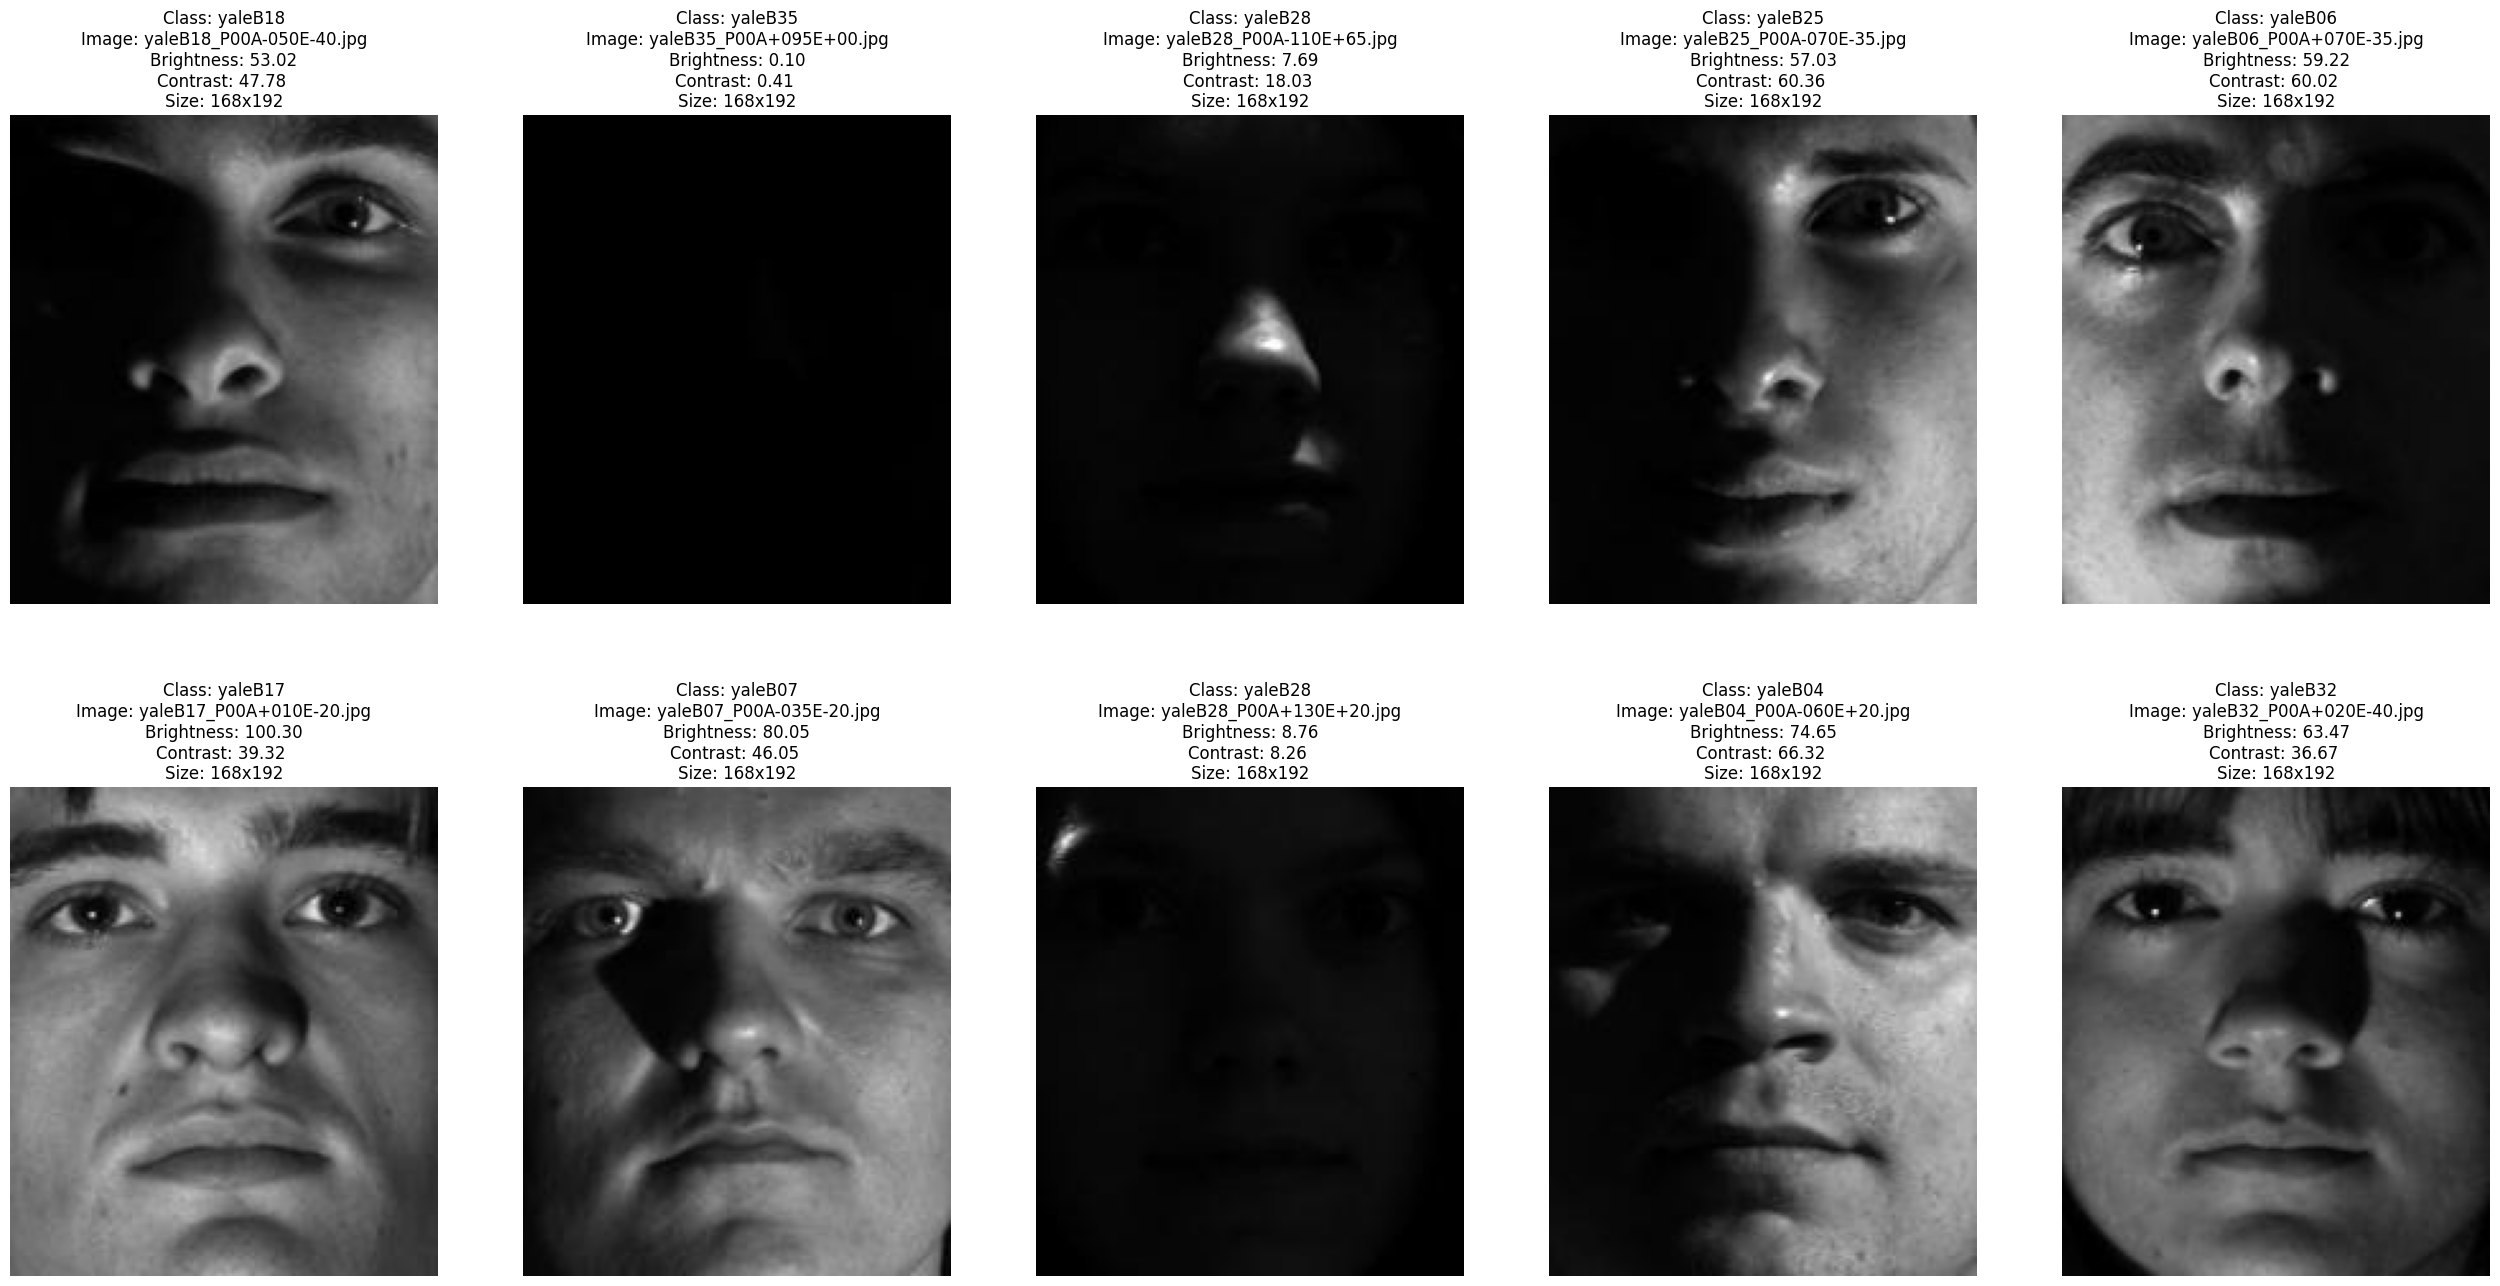

In [ ]:
sample_df = df.sample(n = 10, random_state = 42)

plt.figure(figsize=(32, 16))

for i, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
      stat = ImageStat.Stat(img.convert("L")) #Convert images to grayscale images
      brightness = stat.mean[0]
      contrast = stat.stddev[0]

      width, height = img.size
      # Print size to console
      print(f"Image: {img_name} | Class: {cls} | Size: {width}x{height} | Brightness: {brightness:.1f} | Contrast: {contrast:.1f}")

      plt.subplot(2, 5, i + 1)
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"Class: {cls}\nImage: {img_name}\nBrightness: {brightness:.2f}\nContrast: {contrast:.2f} \nSize: {width}x{height}")

plt.tight_layout
plt.show()

### **Visualize random images with their labels**


---


* This cell randomly selects a set of images from the dataset and displays them in a grid. Each image is shown with its class label, filename, and resolution.
* A colored bar is added at the top of each image to visually distinguish
classes, ensuring consistent color coding across the dataset. This step acts as a sanity check, helping confirm that images are correctly loaded, class labels are accurate, and the dataset is visually diverse.

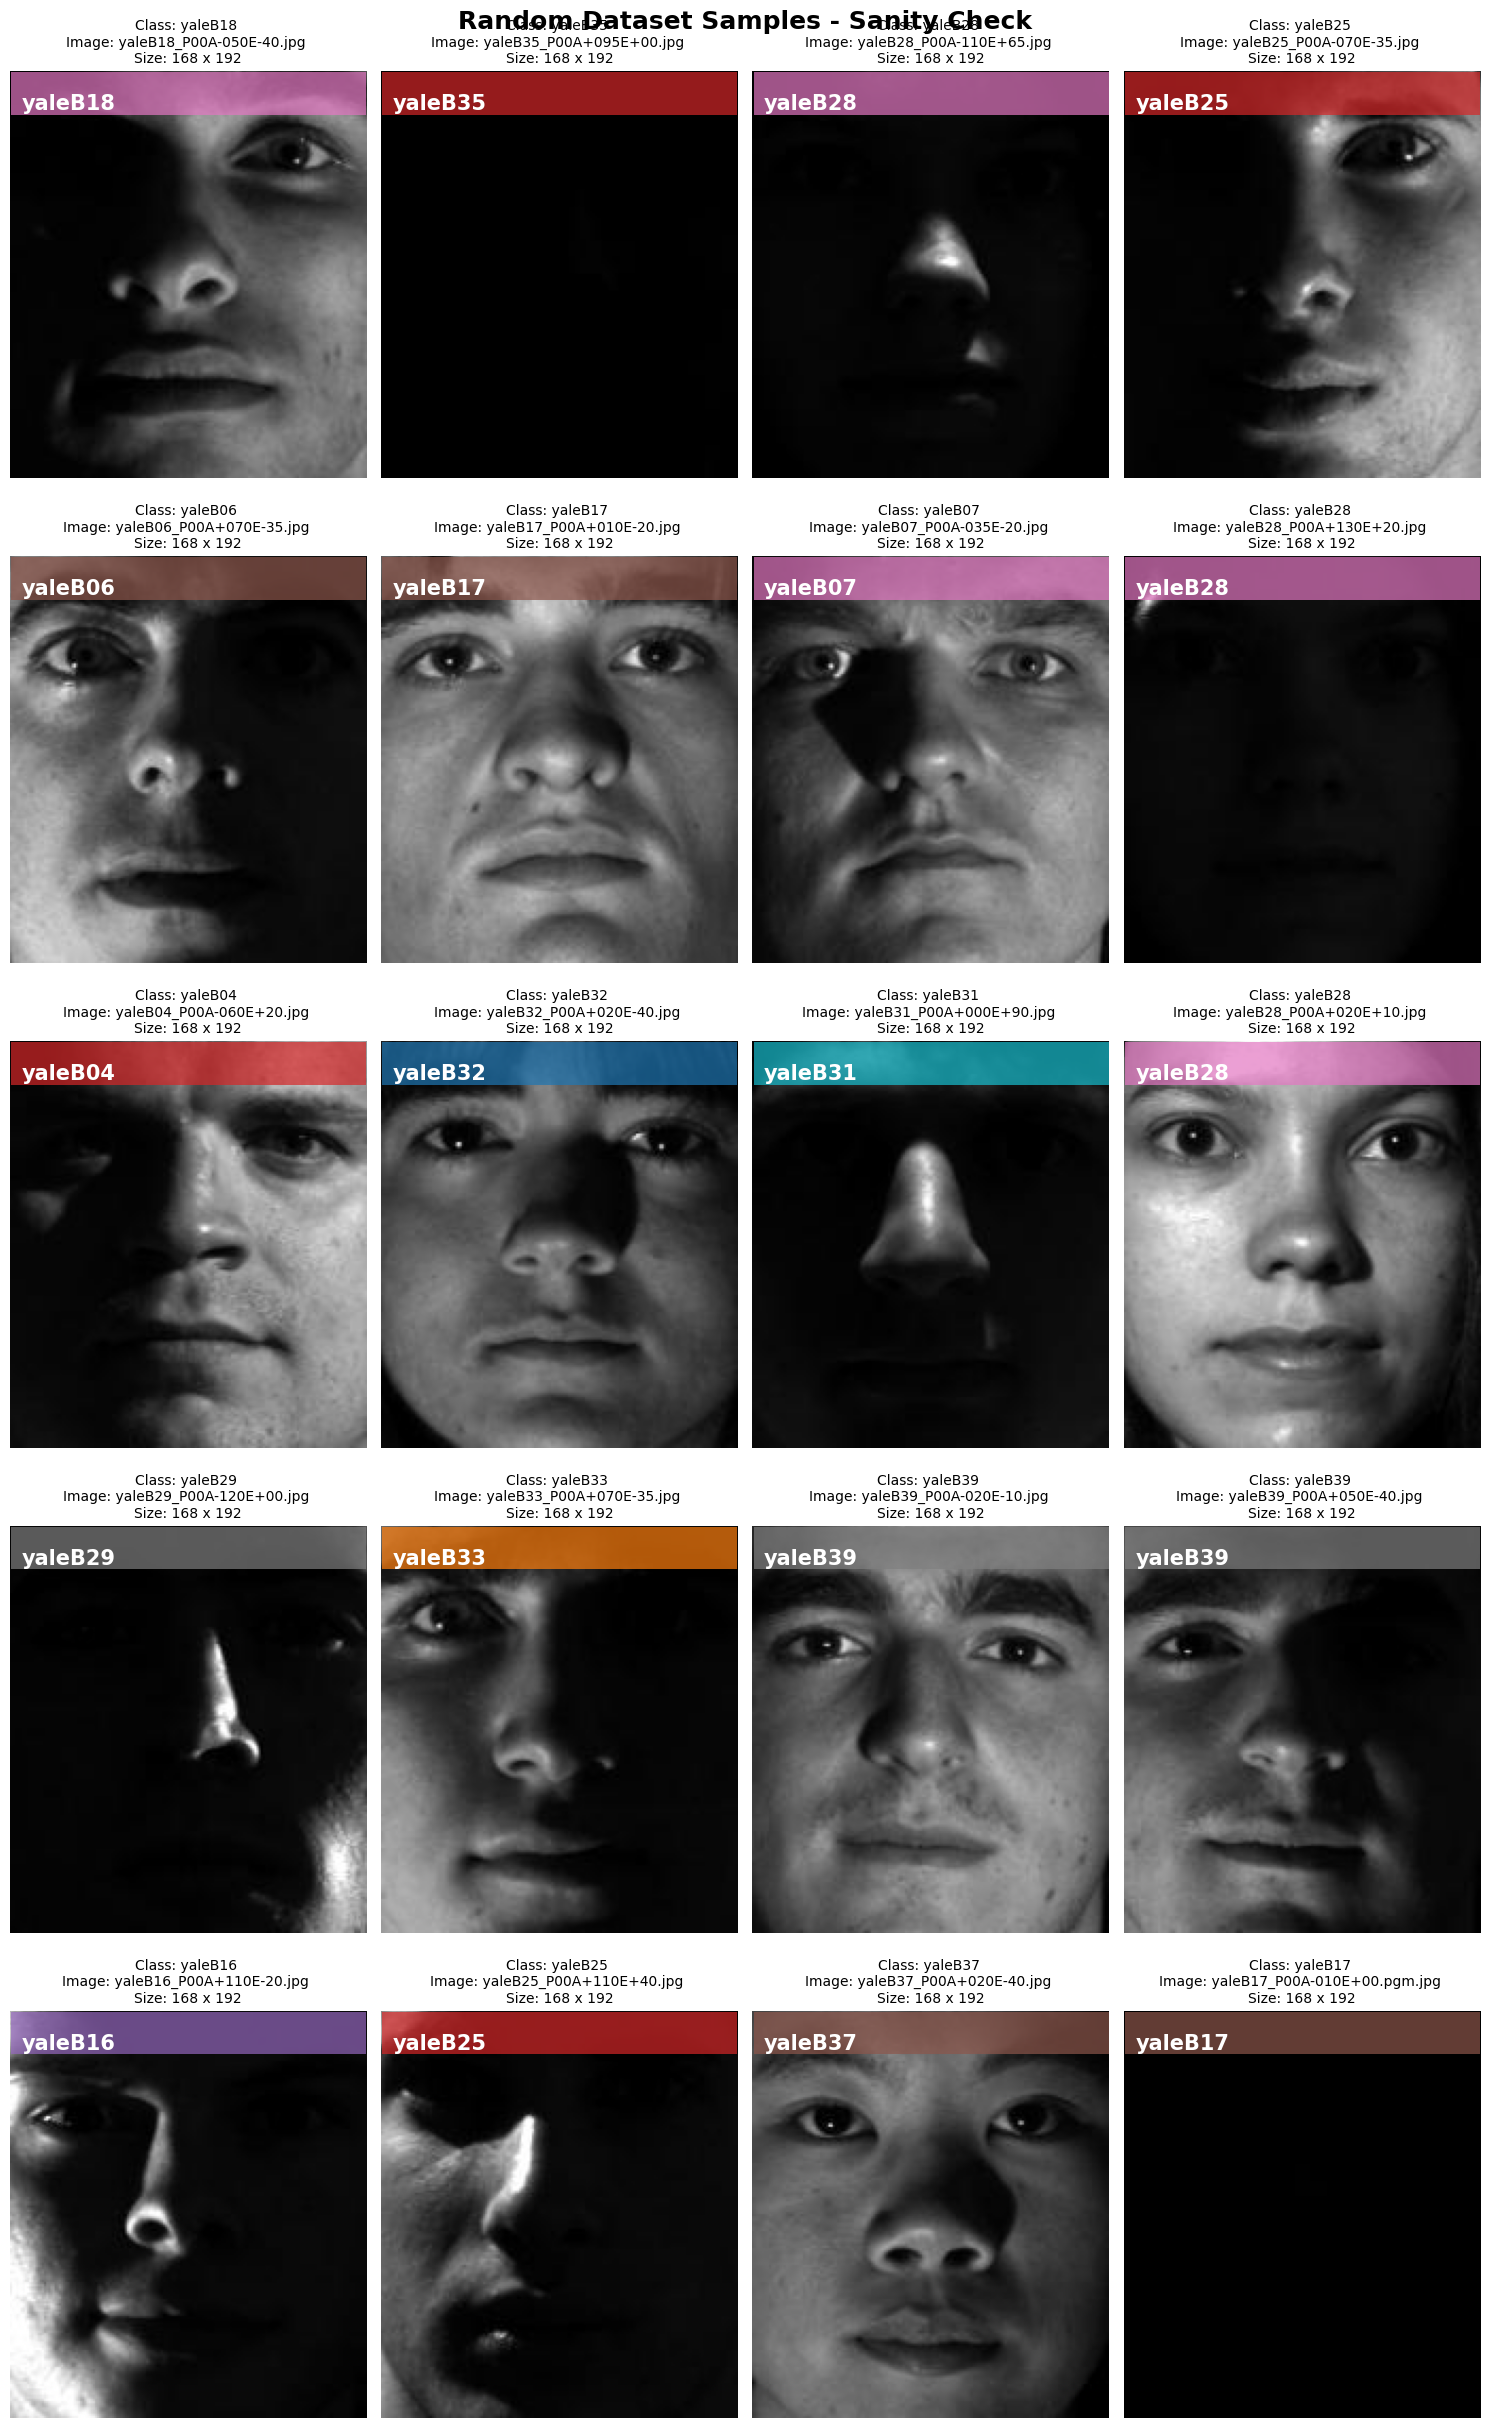

In [ ]:
num_samples = 20
sample_df = df.sample(num_samples, random_state = 42)

classes = sorted(df['class'].unique())
colors = plt.cm.tab10.colors

cols = 4
rows = num_samples // cols + int(num_samples % cols > 0)
plt.figure(figsize=(15, 5 * rows))

for idx, (cls, img_name, full_path) in enumerate(sample_df.values):
    with Image.open(full_path) as img:
      ax = plt.subplot(rows, cols, idx + 1)
      ax.imshow(img)
      width, height = img.size
      ax.set_title(f"Class: {cls} \nImage: {img_name} \nSize: {width} x {height}", fontsize = 10)
      ax.axis('off')

      #rect = patches.Rectangle((0, 0), 1, 1, linewidth = 1, edgecolor = 'r', facecolor = 'none')
      rect = patches.Rectangle((0, 0), img.size[0], 20, linewidth=0, edgecolor=None, facecolor = colors[classes.index(cls) % len(colors)], alpha = 0.7)
      ax.add_patch(rect)

      ax.text(5, 15, cls, fontsize = 15, color = "white", fontweight = "bold", va = "center", ha = "left")

plt.suptitle("Random Dataset Samples - Sanity Check", fontsize = 18, fontweight = "bold")
plt.tight_layout()
plt.show()

### **Perform data consistency check / relationship analysis**


---


* This cell performs a comprehensive quality check on the dataset before training. It verifies whether there are any missing values, duplicate images (both by file name and by actual content), and unexpected file extensions.
* It also inspects the resolution of images across classes to detect inconsistencies and ensures the dataset is balanced by analyzing class distributions. These checks are essential to guarantee that the dataset is clean, consistent, and suitable for training a reliable deep learning model.

In [ ]:
#Check missing files
print("Missing values per column: ")
print(df.isnull().sum())

#Check duplicate files
duplicate_names = df.duplicated().sum()
print(f"\nNumber of duplicate files: {duplicate_names}")

duplicate_names = df[df.duplicated(subset = ['image'], keep = False)]
print(f"Duplicate file names: {len(duplicate_names)}")

#Check if two images or more are the same even if they are having different file names
def get_hash(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['file_hash'] = df['full_path'].apply(get_hash)
duplicate_hashes = df[df.duplicated(subset = ['file_hash'], keep = False)]
print(f"Duplicate image files: {len(duplicate_hashes)}")

#This code below just removing the duplicate files, which means will not be feeded to the model, but will be still in the actual directory
#Important note: duplicates are removed from the dataframe only, not from the actual directory.
#Drop duplicates based on file_hash, keeping the first one

# df_unique = df.drop_duplicates(subset='file_hash', keep='first')
# print(f"After removing duplicates, unique images: {len(df_unique)}")

#Check for images extentions
df['extenstion'] = df['image'].apply(lambda x: Path(x).suffix.lower())
print("File type counts: ")
#print(df['extenstion'].value_counts)
print(df['extenstion'].value_counts())

#Check for resolution relationships
df['Width'] = sizes_df['Width']
df['Height'] = sizes_df['Height']
#print(df.groupby(['Width', 'Height']).size())
print(df.groupby('class')[['Width', 'Height']].agg(['min', 'max', 'mean']))

#Check for class balance (relationship between label and count)
class_summary = df['class'].value_counts(normalize = False).to_frame('Count')
#class_summary['Percentage'] = class_summary['Count'] / class_summary['Count'].sum() * 100
#class_summary
class_summary['Percentage %'] = round((class_summary['Count'] / len(df)) * 100, 2)
print(class_summary)

Missing values per column: 
class        0
image        0
full_path    0
dtype: int64

Number of duplicate files: 0
Duplicate file names: 0
Duplicate image files: 0
File type counts: 
extenstion
.jpg    2470
Name: count, dtype: int64
        Width                  Height                 
          min  max        mean    min  max        mean
class                                                 
yaleB01   168  168  168.000000    192  192  192.000000
yaleB02   168  168  168.000000    192  192  192.000000
yaleB03   168  168  168.000000    192  192  192.000000
yaleB04   168  168  168.000000    192  192  192.000000
yaleB05   168  168  168.000000    192  192  192.000000
yaleB06   168  168  168.000000    192  192  192.000000
yaleB07   168  168  168.000000    192  192  192.000000
yaleB08   168  168  168.000000    192  192  192.000000
yaleB09   168  168  168.000000    192  192  192.000000
yaleB10   168  168  168.000000    192  192  192.000000
yaleB11   168  640  175.261538    192  480  196.430

# **DATA CLEANING PROCESS**

### **Check for corrupted images or outliers**


---

* Before training, it’s important to make sure all images in the dataset are actually usable. In this step, I go through a few checks and cleaning steps.

* First, I check for corrupted images that can’t be opened properly and remove them. Then, I look at the image resolutions and mark any that are way outside the normal size range (outliers).

* Once that’s done, I load the images into memory and check their quality. Some images might be too dark, too bright, or almost blank/gray with very low contrast. I remove the ones that are too bright or blank, and for the dark ones I try to improve them by boosting their brightness and contrast.

* Finally, I run one last check to see if any images are still too dark even after enhancement. This way, I make sure I’m only keeping clean, consistent, and visually useful images in the dataset.


---

*Note: We detected 421 overly dark images. I limited this number to 270 and kept them without removal to allow the model to train on varied types of data. This aligns with the goal of the CroppedYale dataset.*

In [ ]:
corrupted_files = []

for file_path in df['full_path']:
    try:
        with Image.open(file_path) as img:
            img.verify()
    except (UnidentifiedImageError, OSError):
        corrupted_files.append(file_path)

print(f"Found {len(corrupted_files)} corrupted images.")
    #except (IOError, SyntaxError) as e:
        #corrupted_files.append(file_path)

#print(f"Number of corrupted files: {len(corrupted_files)}")

if corrupted_files:
  df = df[~df['full_path'].isin(corrupted_files)].reset_index(drop = True)
  print("Corrupted files removed.")

#Outliers detection
#Resolution-based outlier detection
#width_mean = width_std = sizes_df['Width'].mean(), sizes_df['Width'].std()
#height_mean = height_std = sizes_df['Height'].mean(), sizes_df['Height'].std()

width_mean = sizes_df['Width'].mean()
width_std = sizes_df['Width'].std()
height_mean = sizes_df['Height'].mean()
height_std = sizes_df['Height'].std()

outliers = df[(df['Width'] > width_mean + 3 * width_std) | (df['Width'] < width_mean - 3 * width_std) | (df['Height'] > height_mean + 3 * height_std) | (df['Height'] < height_mean - 3 * height_std)]
#print(f"Number of outliers: {len(outliers)}")
print(f"Found {len(outliers)} resolution outliers.")

df["image"] = df["full_path"].apply(lambda p: Image.open(p).convert('RGB')) #Convert it to RGB for flexibility

too_dark = []
too_bright = []
blank_or_gray = []

# Thresholds
dark_threshold = 30    # Below this is too dark
bright_threshold = 225 # Above this is too bright
low_contrast_threshold = 5  # Low contrast ~ blank/gray

for idx, img in enumerate(df["image"]):
    gray = img.convert('L')
    stat = ImageStat.Stat(gray)
    brightness = stat.mean[0]
    contrast = stat.stddev[0]

    if brightness < dark_threshold:
        too_dark.append(idx)
    elif brightness > bright_threshold:
        too_bright.append(idx)
    elif contrast < low_contrast_threshold:
        blank_or_gray.append(idx)

print(f"Too dark images: {len(too_dark)}")
print(f"Too bright images: {len(too_bright)}")
print(f"Blank/gray images: {len(blank_or_gray)}")

df = df.drop(index=too_bright + blank_or_gray).reset_index(drop=True)

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Enhancing images"):
    img = row["image"]
    if row["full_path"] in df.loc[too_dark, "full_path"].values:
        img = ImageEnhance.Brightness(img).enhance(1.5)
        img = ImageEnhance.Contrast(img).enhance(1.5)
    df.at[idx, "image"] = img  # overwrite image directly in df

print(f"Enhanced images in memory: {len(df)}")

still_dark = []
for idx, img in enumerate(df["image"]):
    gray = img.convert('L')
    stat = ImageStat.Stat(gray)
    brightness = stat.mean[0]
    if brightness < dark_threshold:
        still_dark.append(df.loc[idx, 'full_path'])

print(f"Still too dark after enhancement: {len(still_dark)} images")

Found 0 corrupted images.
Found 28 resolution outliers.
Too dark images: 421
Too bright images: 0
Blank/gray images: 0


Enhancing images: 100%|██████████| 2470/2470 [00:01<00:00, 1442.11it/s]


Enhanced images in memory: 2470
Still too dark after enhancement: 270 images


### **Verify correct labeling of images**


---

This code validates the dataset structure and labels. It first checks if any images are mislabeled by comparing the class recorded in the DataFrame with the folder where the image is stored. Then, it compares the set of classes in the DataFrame with the actual folder names in the dataset to find any missing or extra classes. This helps ensure that labels and folder structures are consistent before training.

In [ ]:
# Point to the extracted dataset, not the zip file location
dataset_root = "/content/my_data/CroppedYale"

# Check mislabeled images
mismatches = []
for i, row in df.iterrows():
    folder_name = os.path.basename(os.path.dirname(row["full_path"]))
    if row["class"] != folder_name:
        mismatches.append((row["full_path"], row["class"], folder_name))

print(f"Found {len(mismatches)} mislabeled images (class vs folder mismatch).")

# Compare classes vs folders
classes_in_df = set(df["class"].unique())
folders_in_fs = {f for f in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, f))}

print("Classes in DF but not in folders:", classes_in_df - folders_in_fs)
print("Folders in FS but not in DF:", folders_in_fs - classes_in_df)

Found 0 mislabeled images (class vs folder mismatch).
Classes in DF but not in folders: set()
Folders in FS but not in DF: set()


### **Check file naming/path issues**


---

This code checks the dataset for file naming problems that could cause errors during training or when moving between systems. It looks for filenames with invalid characters, unwanted spaces, overly long paths, case conflicts, and duplicates across different classes. The output shows how many files have each issue and previews a few examples, helping to clean and organize the dataset before use.

In [ ]:
def check_file_naming_issues(df):
    issues = {"invalid_chars": [], "spaces": [], "long_paths": [], "case_conflicts": [], "duplicate_names_across_classes": []}

    seen_names = {}

    for _, row in df.iterrows():
        fpath = row["full_path"]              # full path
        fname = os.path.basename(fpath)       # just filename
        cls = row["class"]

        # Invalid characters
        if re.search(r'[<>:"/\\|?*]', fname):  # Windows restricted chars
            issues["invalid_chars"].append(fpath)

        # Spaces
        if "  " in fname or fname.startswith(" ") or fname.endswith(" "):
            issues["spaces"].append(fpath)

        # Long paths
        if len(fpath) > 255:
            issues["long_paths"].append(fpath)

        # Case conflicts
        lower_name = fname.lower()
        if lower_name in seen_names and seen_names[lower_name] != cls:
            issues["case_conflicts"].append((fpath, seen_names[lower_name]))
        else:
            seen_names[lower_name] = cls

    # Duplicate names across classes
    duplicates = df.groupby(df["full_path"].apply(os.path.basename))["class"].nunique()
    duplicates = duplicates[duplicates > 1].index.tolist()
    for dup in duplicates:
        dup_paths = df[df["full_path"].str.endswith(dup)]["full_path"].tolist()
        issues["duplicate_names_across_classes"].extend(dup_paths)

    return issues


# Run the check
naming_issues = check_file_naming_issues(df)

for issue_type, files in naming_issues.items():
    print(f"\n{issue_type.upper()} ({len(files)})")
    for f in files[:10]:  # preview first 10
        print(f)


INVALID_CHARS (0)

SPACES (0)

LONG_PATHS (0)

CASE_CONFLICTS (0)

DUPLICATE_NAMES_ACROSS_CLASSES (0)


# **DATA PREPROCESSING PROCESS**

### **Resize images to uniform dimensions**


---

This code resizes all images in the dataset to a fixed size of 192x168 pixels to ensure consistency across the dataset. The resizing is done in place, meaning the original files are overwritten with the resized versions. After resizing, a random sample of 10 images is displayed along with their metadata (class, size, brightness, and contrast). This step verifies that resizing worked correctly and helps inspect image quality before training.


---

*As you can see here, we resized the images before training to prevent any errors during the process.*

All images resized successfully in place!
Image: yaleB18_P00A-050E-40.jpg | Class: yaleB18 | Size: 192x168 | Brightness: 53.0 | Contrast: 47.8
Image: yaleB35_P00A+095E+00.jpg | Class: yaleB35 | Size: 192x168 | Brightness: 0.1 | Contrast: 0.4
Image: yaleB28_P00A-110E+65.jpg | Class: yaleB28 | Size: 192x168 | Brightness: 7.7 | Contrast: 18.0
Image: yaleB25_P00A-070E-35.jpg | Class: yaleB25 | Size: 192x168 | Brightness: 57.0 | Contrast: 60.4
Image: yaleB06_P00A+070E-35.jpg | Class: yaleB06 | Size: 192x168 | Brightness: 59.2 | Contrast: 60.0
Image: yaleB17_P00A+010E-20.jpg | Class: yaleB17 | Size: 192x168 | Brightness: 100.3 | Contrast: 39.3
Image: yaleB07_P00A-035E-20.jpg | Class: yaleB07 | Size: 192x168 | Brightness: 80.0 | Contrast: 46.0
Image: yaleB28_P00A+130E+20.jpg | Class: yaleB28 | Size: 192x168 | Brightness: 8.8 | Contrast: 8.3
Image: yaleB04_P00A-060E+20.jpg | Class: yaleB04 | Size: 192x168 | Brightness: 74.6 | Contrast: 66.3
Image: yaleB32_P00A+020E-40.jpg | Class: yaleB32 | Si

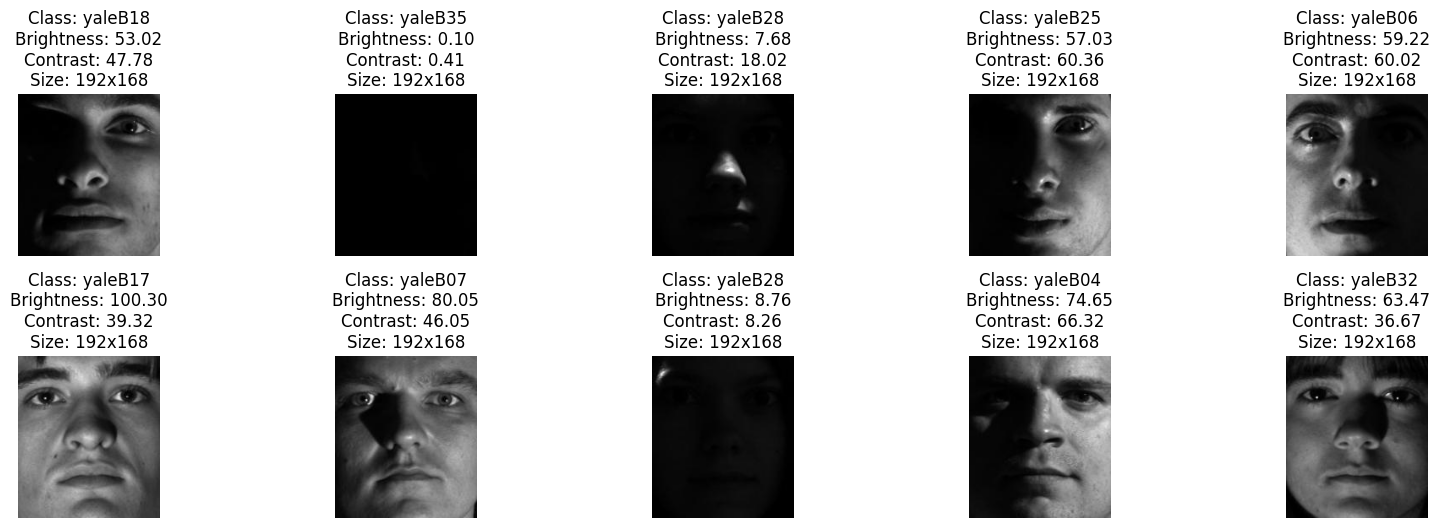

In [ ]:
# Parameters
target_size = (168, 192)  # Desired dimensions

# Resize images in place (overwrite originals)
for img_path in df['full_path']:
    try:
        with Image.open(img_path) as img:
            img_resized = img.resize(target_size, Image.LANCZOS)
            img_resized.save(img_path)  # overwrite original file
    except Exception as e:
        print(f"Error resizing {img_path}: {e}")

print("All images resized successfully in place!")

# Since paths didn't change, we can just reuse df
sample_df = df.sample(n = 10, random_state = 42)

plt.figure(figsize=(16, 8))
for i, row in enumerate(sample_df.itertuples(index = False, name = None)):
    cls = row[0]                # class
    img_name = Path(row[2]).name  # use full_path column for filename
    full_path = row[2]          # use full_path column for opening

    with Image.open(full_path) as img:
        stat = ImageStat.Stat(img.convert("L"))
        brightness = stat.mean[0]
        contrast = stat.stddev[0]
        width, height = img.size

        print(f"Image: {img_name} | Class: {cls} | Size: {height}x{width} | " f"Brightness: {brightness:.1f} | Contrast: {contrast:.1f}")

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Class: {cls}\nBrightness: {brightness:.2f}\nContrast: {contrast:.2f}\nSize: {height}x{width}")

plt.tight_layout()
plt.show()

### **Checking for images size again for double assurance**

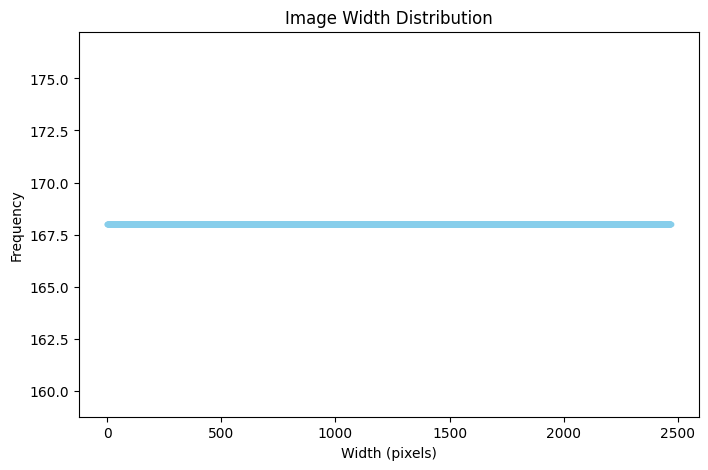

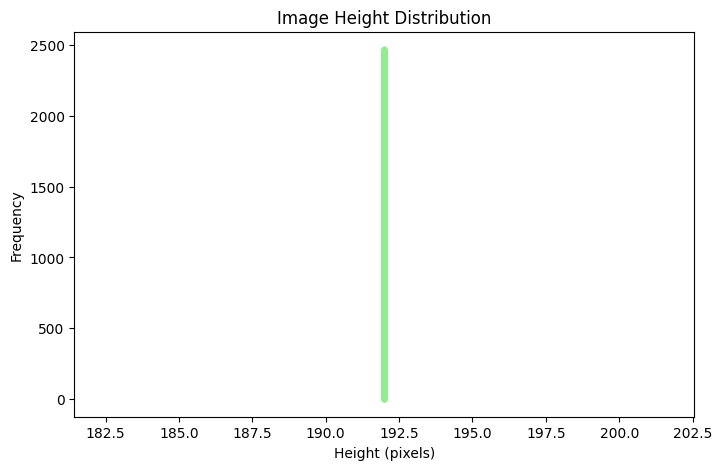

   Width  Height  Count
0    168     192   2470


In [ ]:
image_sizes = []

for file_path in df['full_path']:
    with Image.open(file_path) as img:
        image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

#Width
plt.figure(figsize=(8,5))
plt.scatter(x = range(len(sizes_df)), y = sizes_df['Width'], color='skyblue', s=10)
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

#Height
plt.figure(figsize=(8,5))
plt.scatter(x = sizes_df['Height'], y = range(len(sizes_df)), color='lightgreen', s=10)
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

#For best sure the size of the whole images
unique_sizes = sizes_df.value_counts().reset_index(name='Count')
print(unique_sizes)

### **Normalize pixel values**

---

* This code normalizes all images in the dataset to prepare them for training.
* Each image is converted to grayscale, transformed into a NumPy array, and rescaled so pixel values fall between 0 and 1 instead of `0–255`. The data is also reshaped to `(height, width, 1)` so it matches the expected CNN input format. Labels are stored alongside the images.
* Finally, a few sample images are displayed to confirm the preprocessing worked correctly.

---

*Note: This is not efficient for memory usage, as we are storing all the normalized images in memory, which will consume a lot of it.*





To approach this more efficiently, we can use a `DataGenerator` (like `ImageDataGenerator` in Keras).


---


<details>
<summary>Click to expand code example</summary>

```python
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

paths = df['full_path'].values
labels = df['label'].values

# Split the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths, labels, test_size=0.1, random_state=42, stratify=labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

# Preprocessing function
def preprocess_grayscale_image(path, label, target_size=(192, 168)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)  # Grayscale
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize
    return img, label

# Step 4: Create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

def make_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess_grayscale_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1024)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, training=True)
val_ds   = make_dataset(val_paths, val_labels)
test_ds  = make_dataset(test_paths, test_labels)

# Check image shape and value range
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)  # (batch_size, 192, 168, 1)
    print("Dtype:", images.dtype)        # float32
    print("Min:", tf.reduce_min(images).numpy())  # ~0.0
    print("Max:", tf.reduce_max(images).numpy())  # ~1.0


Normalizing images: 100%|██████████| 2470/2470 [00:01<00:00, 1750.62it/s]


Normalized images shape: (2470, 192, 168, 1)
Labels shape: (2470,)
Pixel range: min = 0.0, max = 1.0


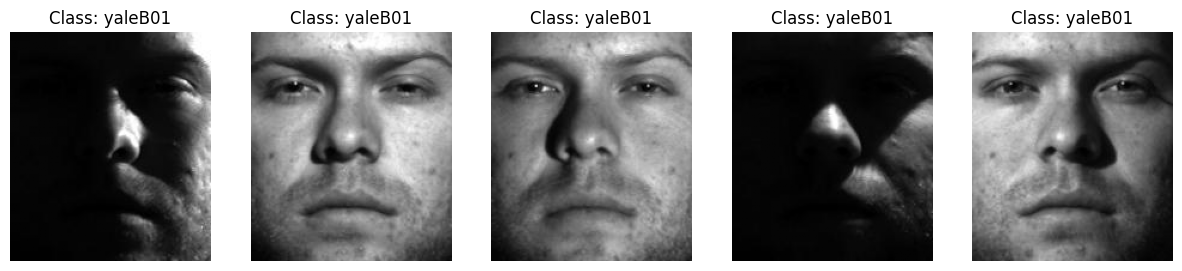

In [ ]:
normalized_images = []
labels = []

for _, row in tqdm(df.iterrows(), total = len(df), desc = "Normalizing images"):
    img_path = row['full_path']
    cls = row['class']

    #Open images and convert to float32 for percision
    img = Image.open(img_path).convert('L')  # 'L' for grayscale images, our images is grayscale by defualt, but this for sure. "convert('RGB')", for RGB images
    img_array = np.array(img, dtype = np.float32) / 255.0 #Normalizing to [0, 1]
    img_array = np.expand_dims(img_array, axis=-1)  # Make it (H, W, 1) for CNN, because CNN expect 3D images

    normalized_images.append(img_array)
    labels.append(cls)

#Convert to NumPy arrays for faster training and compatibility with deep learning frameworks
normalized_images = np.array(normalized_images)
labels = np.array(labels)

print(f"Normalized images shape: {normalized_images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Pixel range: min = {normalized_images.min()}, max = {normalized_images.max()}")

num_images = 5

plt.figure(figsize = (15, 5))

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.clip(normalized_images[i], 0.0, 1.0), cmap = 'gray')
    plt.title(f"Class: {labels[i]}")
    plt.axis('off')

plt.show()

### **Convert labels to numeric (label encoding)**


---

* This code converts class labels from text (e.g., folder names) into numeric values using LabelEncoder.
* Each unique class is assigned an integer ID, which makes the labels suitable for training machine learning models.
* The mapping between original class names and numeric IDs is printed for reference.

In [ ]:
# Initialize LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)
# Overwrite the same column
df['class'] = le.fit_transform(df['class'])

print(df)
print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

      class                                              image  \
0         0  <PIL.Image.Image image mode=RGB size=168x192 a...   
1         0  <PIL.Image.Image image mode=RGB size=168x192 a...   
2         0  <PIL.Image.Image image mode=RGB size=168x192 a...   
3         0  <PIL.Image.Image image mode=RGB size=168x192 a...   
4         0  <PIL.Image.Image image mode=RGB size=168x192 a...   
...     ...                                                ...   
2465     37  <PIL.Image.Image image mode=RGB size=168x192 a...   
2466     37  <PIL.Image.Image image mode=RGB size=168x192 a...   
2467     37  <PIL.Image.Image image mode=RGB size=168x192 a...   
2468     37  <PIL.Image.Image image mode=RGB size=168x192 a...   
2469     37  <PIL.Image.Image image mode=RGB size=168x192 a...   

                                              full_path  \
0     /content/my_data_jpg/CroppedYale/yaleB01/yaleB...   
1     /content/my_data_jpg/CroppedYale/yaleB01/yaleB...   
2     /content/my_data_jpg/Cro

### **Convert images and labels into tensors**


---


I left this here just in case we need to convert our NumPy arrays to tensors. Some frameworks, such as PyTorch, expect the data to be fed as tensors, but as long as we are using TensorFlow, it is okay to feed the model with NumPy arrays.

In [ ]:
# normalized_images = []
# labels = []

# for _, row in tqdm(df.iterrows(), total = len(df), desc = "Loading images"):
#     img_path = row['full_path']
#     cls = row['class']

#     img = Image.open(img_path).convert('RGB')  # already resized
#     img_array = np.array(img, dtype = np.float32)  # pixel values already 0-1 if you normalized before
#     normalized_images.append(img_array)
#     labels.append(cls)

# # Convert to NumPy arrays
# X = np.array(normalized_images, dtype = np.float32)
# y = np.array(labels, dtype = np.int32)

# print(f"Images shape: {X.shape}")
# print(f"Labels shape: {y.shape}")

# Convert to tensors
# X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
# y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)  # integer labels

# print(f"Images shape: {X_tensor.shape}")
# print(f"Labels shape: {y_tensor.shape}")

### **Split dataset into train, validation, and test sets**


---


* This code splits the dataset into training, validation, and test sets.
* First, 10% of the data is set aside as a test set.
* Then, from the remaining 90%, another split is done to create a validation set (9%) and a training set (81%).
* The `stratify` option ensures that all splits keep the same class distribution, which is important for balanced training and evaluation.

In [ ]:
# First, split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    normalized_images, labels, test_size = 0.1, random_state = 42, stratify = labels # Startify makes sure to distribute data from each class to each split
)

# Then, split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val
)

print("Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print("--------------------------------------------------")
print("Train labels sample:", y_train[:10])
print("Validation labels sample:", y_val[:10])
print("Test labels sample:", y_test[:10])

Shapes:
X_train: (2000, 192, 168, 1), y_train: (2000,)
X_val: (223, 192, 168, 1), y_val: (223,)
X_test: (247, 192, 168, 1), y_test: (247,)
--------------------------------------------------
Train labels sample: [30 29 36 13 16 32 37 29 15 24]
Validation labels sample: [25 13 30 35 15 11 19 16  7 18]
Test labels sample: [23 14 15 18 34 34 34 28  6 31]


### **Apply data augmentation**


---

* This block creates a data augmentation pipeline to improve model generalization. It automatically applies random transformations to training images, such as horizontal flips, small rotations, and zooms.
* These variations help the model learn more robust features and reduce overfitting, since the network sees slightly different versions of each image during training.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# **MODEL ARCHITECTURE DESIGN**

### **Buidling a deep CNN classifier**


---

* This block defines the CNN model architecture.
* It starts with a data augmentation layer to improve generalization, followed by multiple convolutional blocks that progressively increase in filters `(32 → 64 → 128 → 256)`.
* Each block consists of convolution layers, batch normalization for stability, max pooling to reduce size, and dropout to prevent overfitting.
* Finally, the output layer uses softmax to classify images into their respective categories.

In [ ]:
# Initialize a sequential model
model = Sequential([data_augmentation])  #First layer is augmented process, so we make sure data augmented before training

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay), input_shape = X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first. Makes feature extraction stronger
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size = (2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate = 0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

num_classes = df['class'].nunique()
# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 192, 168, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 192, 168, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 168, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 192, 168, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 168, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 84, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,342,918 (8.94 MB)

 Trainable params: 2,340,998 (8.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

### **Training the model**


---

* This block sets up and runs the training process.
* The model is compiled with the Adam optimizer, a sparse categorical crossentropy loss function, and accuracy as the evaluation metric.
* Training runs for up to 50 epochs with a batch size of 64, while validation data monitors progress.
* Two callbacks are included: ReduceLROnPlateau lowers the learning rate when validation loss stalls, and EarlyStopping halts training if no improvement is observed, restoring the best weights.
* This combination ensures efficient training, prevents overfitting, and improves convergence.


---

*You'll see the model perform worse at the beginning but improve during training, which is common in deep learning tasks. You'll also see that the model uses callback methods to imporve the model without any issues.*

In [ ]:
# Set the batch size for the training
batch_size = 64

# Set the maximum number of epochs for the training
epochs = 50

# Define the optimizer (Adam)
optimizer = Adam(learning_rate = 0.0005)

# Used 'sparse_categorical_crossentropy' because our labels (classes) are integers not binarized as [0,0,1,....,1,1,0,1] --> This called (one-hot encoded labels)
# Compile the model with the defined optimizer, loss function, and metrics
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy'])

# Add ReduceLROnPlateau callback to dynamically lower the learning rate.
# If validation loss stalls for 10 consecutive epochs, the learning rate is halved (factor=0.5) to aid convergence.
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, min_lr = 0.00001, verbose = 1)

# Add EarlyStopping callback to halt training if validation loss shows no improvement for 40 epochs.
# The `restore_best_weights=True` parameter ensures the model reverts to the weights from the epoch
# with the lowest validation loss.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights = True, verbose = 1)

# Train the model using the specified batch size and number of epochs.
# Validation data is used for real-time performance monitoring.
# Integrated callbacks handle dynamic learning rate adjustment on validation loss plateau
# Early termination if no improvement is detected.
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks = [reduce_lr, early_stopping], verbose = 1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 471ms/step - accuracy: 0.0486 - loss: 10.7774 - val_accuracy: 0.0269 - val_loss: 4.6498 - learning_rate: 5.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 377ms/step - accuracy: 0.1307 - loss: 5.8837 - val_accuracy: 0.0269 - val_loss: 6.4400 - learning_rate: 5.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.2369 - loss: 4.8901 - val_accuracy: 0.0269 - val_loss: 8.9262 - learning_rate: 5.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - accuracy: 0.3168 - loss: 4.0922 - val_accuracy: 0.0269 - val_loss: 12.5840 - learning_rate: 5.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 381ms/step - accuracy: 0.4260 - loss: 3.6289 - val_accuracy: 0.0269 - val_loss: 9.6922 - learning_rate: 5.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - accuracy: 0.4775 - loss: 2.9966 - val_accuracy: 0.0224 - val_loss: 13.9350 - learning_rate: 5.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - 

# **MODEL EVALUATION**

### **Model evaluation #1**


---

* This block evaluates the trained CNN on the test dataset.
* It first reports accuracy, then calculates Precision, Recall, and F1-score using macro-averaging to ensure fair performance measurement across all classes.
* These metrics provide deeper insight than accuracy alone, especially when dealing with class imbalance.


---

*As you see the `"Precision: 0.9793 | Recall: 0.9756 | F1-score: 0.9754"`, which is good.*

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 1) #Gives probability distributions for each class
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model.predict(X_test), axis = 1)
precision = precision_score(y_test, y_pred, average = 'macro')
recall = recall_score(y_test, y_pred, average = 'macro')
f1 = f1_score(y_test, y_pred, average = 'macro')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9650 - loss: 0.2483
Test Accuracy: 0.9757
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Precision: 0.9793, Recall: 0.9756, F1-score: 0.9754


### **Model evaluation #2**


---

* In this step, we evaluate the performance of the trained model on the test dataset.
* First, the model predicts class probabilities for each sample, which are then converted into final class labels.
* We generate a classification report to check precision, recall, and F1-score for each class, and a confusion matrix to visualize misclassifications.
* Finally, we plot ROC curves for all classes (one-vs-rest approach) to assess how well the model separates each class from the others.
* As long as our values are close to 1.00, which is a good sign, it means our model is performing well and our datasets are fine. Also, if we look at our confusion matrix, we'll see it is mostly diagonal, indicating that our model is making correct predictions.


---

**Just some useful details:**
* **Accuracy** can be misleading when classes are imbalanced.
* **Precision** helps when you want to be sure your positive predictions are correct (avoid false alarms).
* **Recall** helps when you want to catch as many actual positives as possible (avoid missing any).
* **F1-score** balances both, so you get a single measure of overall performance when you care about both precision and recall.
* **Support** of each class is the number of images that have been tested and belong to that class. If we sum all the support values, it will equal 247, which is the total number of images in our test data.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         7
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         6
           9       0.75      1.00      0.86         6
          10       1.00      1.00      1.00         7
          11       0.88      1.00      0.93         7
          12       1.00      1.00      1.00         6
          13       1.00      0.83      0.91         6
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00

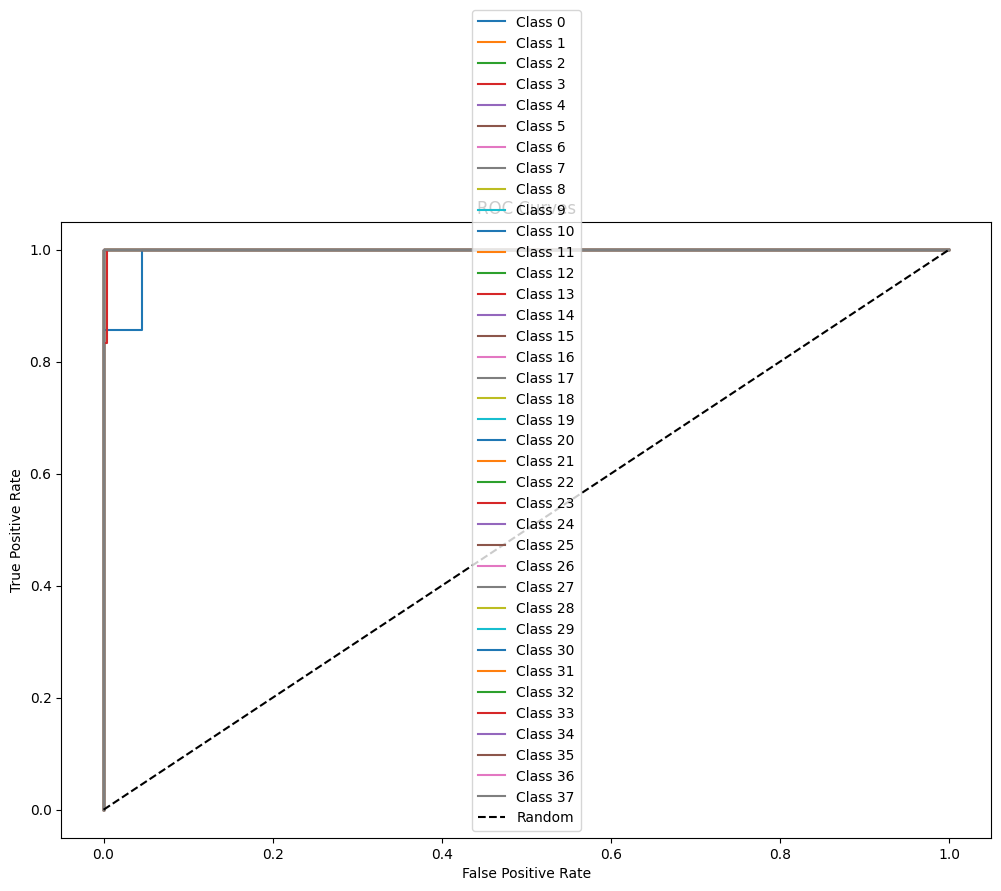

In [ ]:
# Predict class probabilities
y_probs = model.predict(X_test)           #shape: (num_samples, num_classes)
y_pred = np.argmax(y_probs, axis = 1)       #Convert probs to predicted class labels

# Classification report: precision, recall, F1-score
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

#ROC curve for multi-class (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))  # shape: (num_samples, num_classes)

plt.figure(figsize=(12,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### **Model evaluation #3**


---
* This cell evaluates the model’s performance per class by calculating precision, recall, F1-score, and support.
* The results are stored in a table and sorted by F1-score to easily identify the weakest classes.
* Additionally, macro-averaged metrics are computed to summarize overall performance across all classes, treating each class equally.


In [ ]:
y_pred = np.argmax(model.predict(X_test), axis = 1)

# Get metrics per class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)

df_metrics = pd.DataFrame({
    'Class': np.arange(num_classes),
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
})

# Sort by F1-score ascending to quickly see worst performing classes
df_metrics_sorted = df_metrics.sort_values(by = 'F1-score')
print(df_metrics_sorted)

# Macro averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average = 'macro')
print(f"\nMacro Avg -> Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-score: {f1_macro:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
    Class  Precision    Recall  F1-score  Support
9       9   0.750000  1.000000  0.857143        6
13     13   1.000000  0.833333  0.909091        6
30     30   1.000000  0.833333  0.909091        6
33     33   1.000000  0.833333  0.909091        6
20     20   1.000000  0.857143  0.923077        7
25     25   0.857143  1.000000  0.923077        6
23     23   1.000000  0.857143  0.923077        7
2       2   1.000000  0.857143  0.923077        7
26     26   0.857143  1.000000  0.923077        6
11     11   0.875000  1.000000  0.933333        7
34     34   0.875000  1.000000  0.933333        7
7       7   1.000000  1.000000  1.000000        7
4       4   1.000000  1.000000  1.000000        6
0       0   1.000000  1.000000  1.000000        6
5       5   1.000000  1.000000  1.000000        7
6       6   1.000000  1.000000  1.000000        6
15     15   1.000000  1.000000  1.000000        6
14     14   1.000000  1.000000  1.000000        7
12     12   

### **Model evaluation #4**


---

* This cell visualizes the confusion matrix as a heatmap. The confusion matrix summarizes how well the model’s predictions match the true labels, showing correct classifications along the diagonal and misclassifications off-diagonal.
* The heatmap provides an intuitive way to spot which classes are being confused with each other.


---


**Here also a clear vision of evaluation which:**
* The confusion matrix displays the performance of a classification model:
* Y-axis = True classes (actual labels).
* X-axis = Predicted classes (model's predictions).
* Each cell shows the number of predictions for that true-predicted class pair.
* Color Intensity:
* Darker/blue cells indicate higher values — more correct predictions.
* The diagonal cells (true class = predicted class) represent correct predictions. Darker diagonal cells mean better performance.
* Off-diagonal cells (true ≠ predicted) show misclassifications. Lighter colors here suggest more errors.

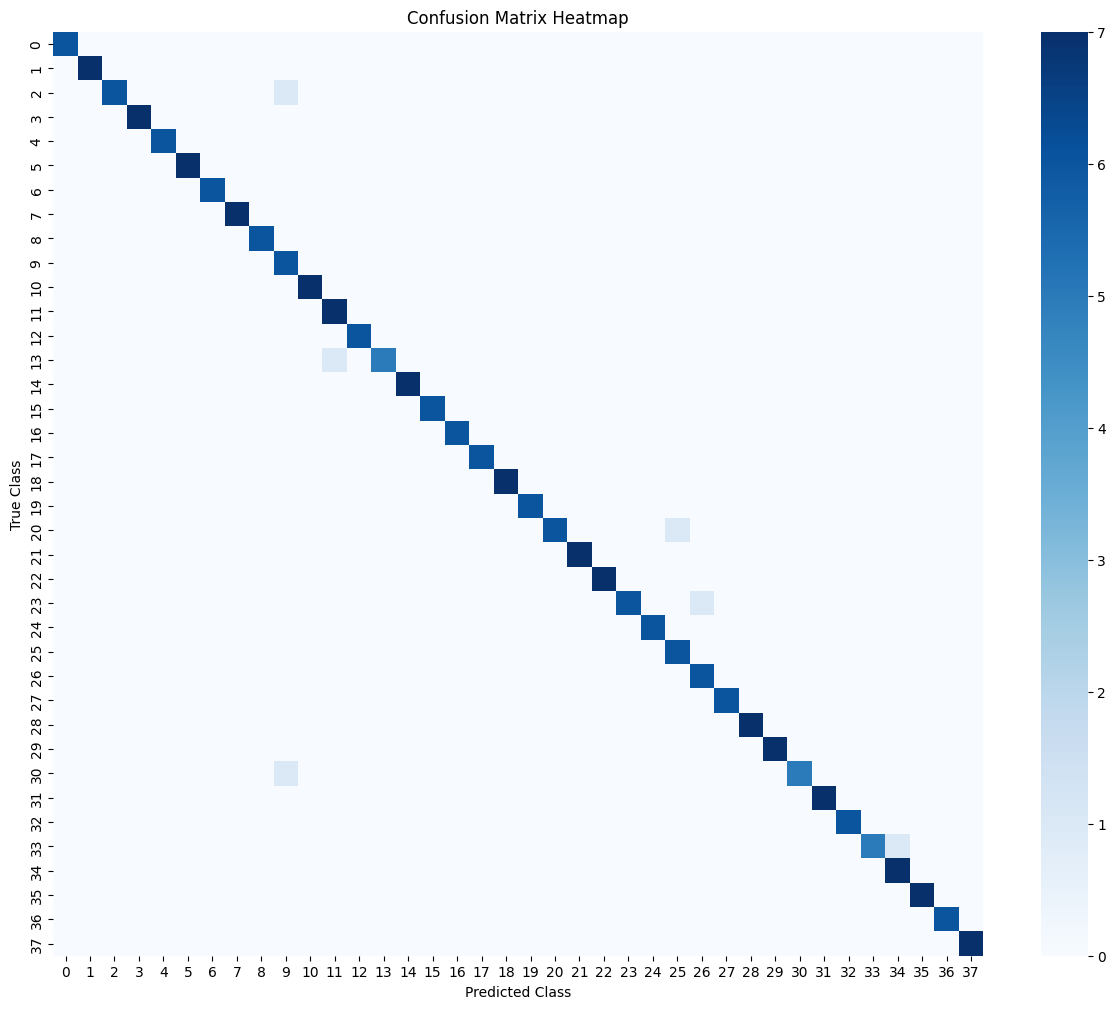

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (15,12))
sns.heatmap(cm, annot = False, fmt = 'd', cmap = 'Blues')
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix Heatmap")
plt.show()

### **Model evaluation #5**


---

* This cell computes and plots the macro-average ROC curve for multi-class classification.
* The ROC curve shows the trade-off between True Positive Rate and False Positive Rate.
* By averaging across all classes, we get an overall measure of the model’s ability to distinguish between classes.
* The AUC score summarizes this performance, where values closer to 1 indicate better classification.


---
**The ROC curve (Receiver Operating Characteristic curve) plots the model's performance by showing:**
* False Positive Rate (FPR) on the x-axis.
* True Positive Rate (TPR) on the y-axis.

**Random Line:**
The dashed random line ([0,1], [0,1]) represents a random classifier. If the ROC curve is near this line, the model is performing no better than random guessing. Ideally, the curve should be above this line.

**AUC (Area Under the Curve):**
* AUC = 0.5: Random guessing.
* AUC = 1.0: Perfect model performance.
> **AUC = 0.9998: Very strong performance, with the model distinguishing classes almost perfectly.**

**Interpretation:**
* A higher AUC indicates better performance. An `AUC of 0.9998` means the model is performing exceptionally well in classifying the data.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


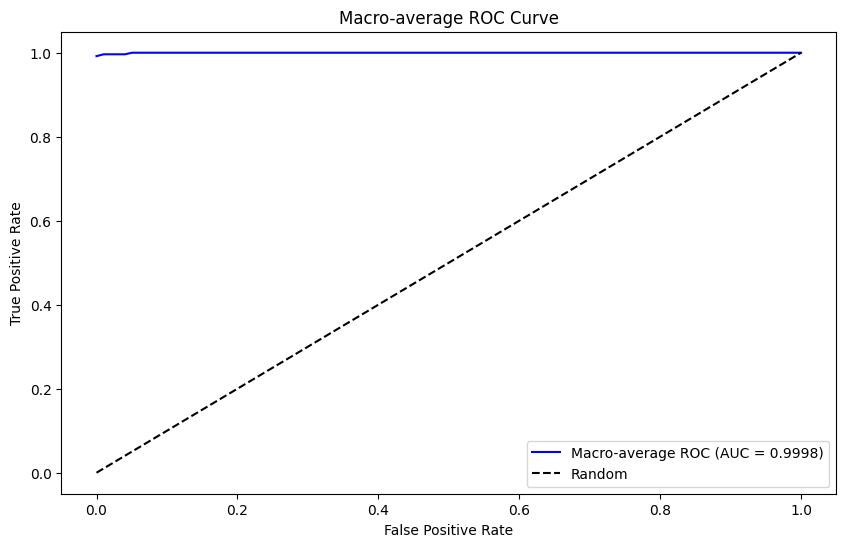

In [ ]:
y_test_bin = label_binarize(y_test, classes = np.arange(num_classes))
y_probs = model.predict(X_test)

# Compute macro-average ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= num_classes
roc_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize = (10,6))
plt.plot(all_fpr, mean_tpr, color='b', label = f'Macro-average ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend()
plt.show()

# **NOISING PROCESS**

### **Add salt and pepper noise to our dataset**


---
* This cell prepares the dataset by first padding all images so their dimensions are multiples of 16, which is often required by convolutional networks, especially U-Net-Based CNN Autoencoders with skip connections.
* Then, it introduces salt-and-pepper noise to create noisy versions of the images, helping the model learn to handle corrupted inputs.
* Finally, it visualizes an example of an original image alongside its noisy counterpart for comparison.


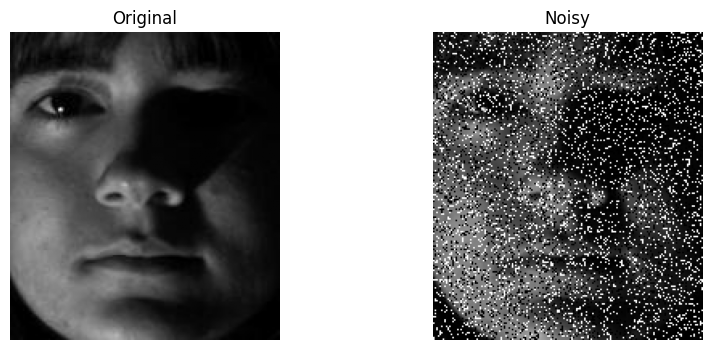

In [ ]:
def pad_to_multiple(images, multiple = 16):
    """Pad images to the nearest multiple of `multiple` for height and width"""
    padded_images = []
    for img in images:
        h, w = img.shape[:2]
        new_h = ((h - 1) // multiple + 1) * multiple
        new_w = ((w - 1) // multiple + 1) * multiple
        pad_h = new_h - h
        pad_w = new_w - w
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        padded = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode = 'constant', constant_values = 0)
        padded_images.append(padded)
    return np.array(padded_images, dtype=np.float32)

def add_salt_pepper_noise(img, amount = 0.3):

    noisy = img.copy()
    h, w = img.shape[:2]
    num_salt = np.ceil(amount * h * w * 0.5).astype(int)
    num_pepper = np.ceil(amount * h * w * 0.5).astype(int)

    # Salt (white) pixels
    coords = [np.random.randint(0, i, num_salt) for i in (h, w)]
    noisy[coords[0], coords[1], 0] = 1.0  # If normalized to [0,1]

    # Pepper (black) pixels
    coords = [np.random.randint(0, i, num_pepper) for i in (h, w)]
    noisy[coords[0], coords[1], 0] = 0.0 # If normalized to [0,1]

    return noisy

# Apply to first train, valid, and test images
X_train_noisy = np.array([add_salt_pepper_noise(img) for img in X_train])
X_valid_noisy = np.array([add_salt_pepper_noise(img) for img in X_val])
X_test_noisy = np.array([add_salt_pepper_noise(img) for img in X_test])

X_train_padded = pad_to_multiple(X_train)
X_val_padded   = pad_to_multiple(X_val)
X_test_padded  = pad_to_multiple(X_test)

X_train_noisy_padded = pad_to_multiple(X_train_noisy)
X_val_noisy_padded = pad_to_multiple(X_valid_noisy)
X_test_noisy_padded = pad_to_multiple(X_test_noisy)

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.imshow(X_train[0,:,:,0], cmap = 'gray')  #Use cmap='gray' to ensure our data displayed in grayscale view
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(X_train_noisy[0,:,:,0], cmap = 'gray')
plt.title("Noisy")
plt.axis('off')
plt.show()

### **Here checking the shape noisy data**

Original image shape: (192, 168, 1)
Noisy image shape:    (192, 168, 1)


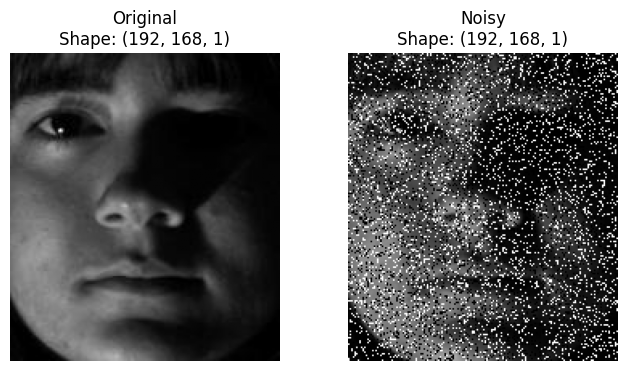

In [ ]:
# Pick an index to visualize
idx = 0

print("Original image shape:", X_train[idx].shape)
print("Noisy image shape:   ", X_train_noisy[idx].shape)

plt.figure(figsize = (8,4))

# Original image
plt.subplot(1,2,1)
plt.imshow(X_train[idx].squeeze(), cmap = 'gray')  # .squeeze() removes the last channel if 1
plt.title(f"Original\nShape: {X_train[idx].shape}")
plt.axis('off')

# Noisy image
plt.subplot(1,2,2)
plt.imshow(X_train_noisy[idx].squeeze(), cmap = 'gray')
plt.title(f"Noisy\nShape: {X_train_noisy[idx].shape}")
plt.axis('off')

plt.show()

**Evaluating the noisy data on the recently trained model shows an accuracy of 2%, which is very poor. To address this issue, we will later build a U-Net-based CNN autoencoder model with skip connections.**

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_noisy, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model.predict(X_test_noisy), axis=1)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0270 - loss: 31.7069
Test Accuracy: 0.0243
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Precision: 0.0006, Recall: 0.0263, F1-score: 0.0012


**As you can see, the ROC curve is above the random curve, but it’s still quite close to it, indicating that the model’s performance is only slightly better than random guessing, but we still need some improvments.**

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


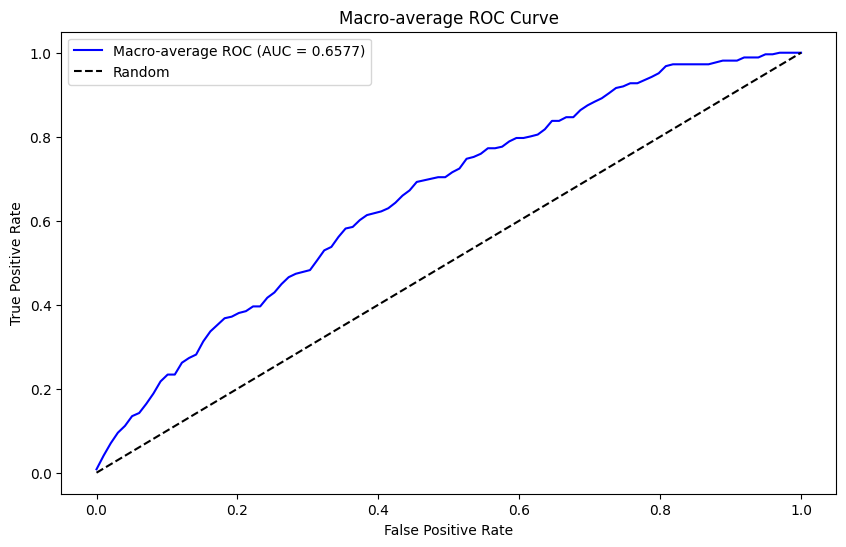

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
y_probs = model.predict(X_test_noisy)

# Compute macro-average ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= num_classes
roc_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10,6))
plt.plot(all_fpr, mean_tpr, color='b', label=f'Macro-average ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend()
plt.show()

# **U-NET-BASED CNN AUTOENCODER MODEL WITH SKIP CONNECTIONS**

***This is my first version of a CNN autoencoder, but it didn't include U-Net skip connections. While it performed well, it didn't provide the best results. I’m leaving it here for anyone interested in trying it.***


---
* This cell builds and trains a convolutional autoencoder for image denoising.
* The encoder compresses noisy input images into a latent representation, and the decoder reconstructs clean images from it.
* The model uses convolutional layers, batch normalization, pooling, dropout, and upsampling.
* It is trained with noisy images as input and clean images as targets, using MSE loss and Adam optimizer, with callbacks for adaptive learning rate and early stopping.



In [ ]:
# # Set the input shape
# input_shape = X_train_padded.shape[1:]  # (height, width, channels)
# weight_decay = 0.0001

# # Encoder
# input_img = Input(shape=input_shape)
# x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(input_img)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.2)(x)

# x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.3)(x)

# x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.4)(x)

# x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
# x = BatchNormalization()(x)
# encoded = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(x)
# x = BatchNormalization()(encoded)
# x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.5)(x)

# # Decoder
# x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D((2, 2))(x)

# x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D((2, 2))(x)

# x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D((2, 2))(x)

# x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
# x = BatchNormalization()(x)
# x = UpSampling2D((2, 2))(x)

# # Final layer: reconstruct the original image
# output_img = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

# # Define the model
# autoencoder = Model(input_img, output_img)
# autoencoder.summary()

# autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# # Optional callbacks
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

# # Fit the model
# history = autoencoder.fit(X_train_noisy_padded, X_train_padded, batch_size=64, epochs=50, validation_data=(X_val_noisy_padded, X_val_padded), callbacks=[reduce_lr, early_stopping], verbose=1)

### **Building U-Net-based CNN autoencoder model with skip connections**


---

This cell builds a U-Net style convolutional autoencoder.
The encoder compresses the input image into feature representations, while the decoder reconstructs the output image using upsampling.

Unlike a plain autoencoder, this model uses skip connections: at each decoding stage, the upsampled features are concatenated with the corresponding encoder feature maps from the same resolution. This concatenation allows the decoder to access both:

* High-level semantic features from the bottleneck (what the image is).
* Low-level spatial details from earlier encoder layers (where edges, shapes, and textures are).

By reintroducing these fine details that would otherwise be lost during pooling, the model achieves sharper, more accurate reconstructions. This makes U-Net autoencoders particularly powerful for tasks like denoising, segmentation, and image-to-image translation.

The final layer outputs an image of the same size and number of channels as the input, making it suitable for denoising and image reconstruction tasks.

In [ ]:
# Set input shape and weight decay
input_shape = X_train_padded.shape[1:]  # (height, width, channels)
weight_decay = 0.0001

inputs = Input(shape=input_shape)

# Encoder
c1 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(inputs)
c1 = BatchNormalization()(c1)
c1 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2))(c1)
p1 = Dropout(0.2)(p1)

c2 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2))(c2)
p2 = Dropout(0.3)(p2)

c3 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2))(c3)
p3 = Dropout(0.4)(p3)

c4 = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(p3)
c4 = BatchNormalization()(c4)
c4 = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))(c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D((2, 2))(c4)
p4 = Dropout(0.5)(p4)

# Bottleneck
b = Conv2D(512, (3, 3), padding='same', activation='relu')(p4)
b = BatchNormalization()(b)
b = Conv2D(512, (3, 3), padding='same', activation='relu')(b)
b = BatchNormalization()(b)

# Decoder (with skip connections)
u4 = UpSampling2D((2, 2))(b)
u4 = Concatenate()([u4, c4])
d4 = Conv2D(256, (3, 3), padding='same', activation='relu')(u4)
d4 = BatchNormalization()(d4)
d4 = Conv2D(256, (3, 3), padding='same', activation='relu')(d4)
d4 = BatchNormalization()(d4)

u3 = UpSampling2D((2, 2))(d4)
u3 = Concatenate()([u3, c3])
d3 = Conv2D(128, (3, 3), padding='same', activation='relu')(u3)
d3 = BatchNormalization()(d3)
d3 = Conv2D(128, (3, 3), padding='same', activation='relu')(d3)
d3 = BatchNormalization()(d3)

u2 = UpSampling2D((2, 2))(d3)
u2 = Concatenate()([u2, c2])
d2 = Conv2D(64, (3, 3), padding='same', activation='relu')(u2)
d2 = BatchNormalization()(d2)
d2 = Conv2D(64, (3, 3), padding='same', activation='relu')(d2)
d2 = BatchNormalization()(d2)

u1 = UpSampling2D((2, 2))(d2)
u1 = Concatenate()([u1, c1])
d1 = Conv2D(32, (3, 3), padding='same', activation='relu')(u1)
d1 = BatchNormalization()(d1)
d1 = Conv2D(32, (3, 3), padding='same', activation='relu')(d1)
d1 = BatchNormalization()(d1)

# Output layer
output_img = Conv2D(input_shape[-1], (3, 3), activation='sigmoid', padding='same')(d1)

# Define the model
autoencoder = Model(inputs, output_img)
autoencoder.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 192, 176,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 192, 176,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 176,  │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 192, 176,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 176,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 96, 88,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 96, 88,    │          0 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 96, 88,    │     18,496 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 88,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 96, 88,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 88,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 48, 44,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 48, 44,    │          0 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 48, 44,    │     73,856 │ dropout_5[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 44,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 48, 44,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 44,    │        512 │ conv2d_13[0][0] 

 Total params: 7,858,113 (29.98 MB)

 Trainable params: 7,852,225 (29.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

### **Training U-Net-based CNN autoencoder model with skip connections**


---

* We train the denoising autoencoder with a custom loss that combines MSE (pixel-wise accuracy) and SSIM (perceptual/structural similarity).
* MSE reduces overall error but can blur details; SSIM preserves edges, contrast, and structure.
* The loss is `0.8*MSE + 0.2*(1-SSIM)`, assuming images are scaled to [0,1]. The model is compiled with Adam `(lr=0.0005)` and trained on noisy → clean pairs.
* We use ReduceLROnPlateau to lower the learning rate when validation loss stalls and EarlyStopping to halt training and restore the best weights when progress stops.

In [ ]:
def combined_ssim_mse_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))
    ssim_val = tf.image.ssim(y_true, y_pred, max_val = 1.0) #Assumes pixel values are in [0, 1] (because max_val=1.0). If your images were in [0,255], you’d set max_val=255.0 or rescale
    ssim_loss = 1 - tf.reduce_mean(ssim_val) #Turn similarity into a loss: higher SSIM → lower loss
    return 0.8 * mse_loss + 0.2 * ssim_loss

autoencoder.compile(optimizer=Adam(learning_rate = 0.0005), loss=combined_ssim_mse_loss)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 10, min_lr = 1e-5, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', patience = 40, restore_best_weights = True, verbose = 1)

# Training
history = autoencoder.fit(X_train_noisy_padded, X_train_padded, batch_size = 64, epochs = 50, validation_data = (X_val_noisy_padded, X_val_padded), callbacks = [reduce_lr, early_stopping], verbose = 1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - loss: 0.2969 - val_loss: 0.2206 - learning_rate: 5.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 708ms/step - loss: 0.1241 - val_loss: 0.2722 - learning_rate: 5.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 753ms/step - loss: 0.0924 - val_loss: 0.2340 - learning_rate: 5.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 761ms/step - loss: 0.0775 - val_loss: 0.2330 - learning_rate: 5.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 730ms/step - loss: 0.0654 - val_loss: 0.2186 - learning_rate: 5.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 777ms/step - loss: 0.0542 - val_loss: 0.2036 - learning_rate: 5.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 756ms/step - loss: 0.0480 - val_loss: 0.2000 - learning_rate: 5.0000e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 754ms/step - loss: 0.0426 - val_loss: 0.1857 - learning_rate: 5.0000e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 770ms/step - loss: 0.0395 - val_loss: 0.

### **Feature extractor**


---
* Instead of using the full autoencoder (which reconstructs images), it defines an encoder-only model that outputs the compressed bottleneck features.
* These extracted features capture the essential information of the input images and can be used for further machine learning tasks.


---

***Note: I'm not using it, but left it here in case if we can use it as a feature extractor later on...***

In [ ]:
#For feature extraction from test data
X_test_noisy = np.array([cv2.resize(img, (176, 192)) for img in X_test_noisy])
X_test_noisy = np.expand_dims(X_test_noisy, axis=-1)

encoder_model = Model(inputs=autoencoder.input, outputs=b)
features = encoder_model.predict(X_test_noisy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 504ms/step


# **U-NET-BASED CNN AUTOENCODER MODEL WITH SKIP CONNECTIONS EVALUATION**

### **U-net evaluation #1**


---

* This code resizes the test set for U-net model, adds noise, and then tests the trained autoencoder’s denoising ability by comparing the noisy inputs with the clean ground truth.
* The output tells you how well your model generalizes to unseen data.


---

**We evaluating U-Net models with loss, less lose value; more high quality images.**

In [ ]:
X_test_resized = np.array([resize(img, (192, 176)).numpy() for img in X_test])
X_test_noisy = np.array([add_salt_pepper_noise(img) for img in X_test_resized])

autoencoder.evaluate(X_test_noisy, X_test_resized)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 913ms/step - loss: 0.0093


0.00926429033279419

### **U-net evaluation #2**


---


### **As you can see here, we can say that the original images are nearly identical to the reconstructed images, and this is the power of U-Net models with skip connections.**

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step


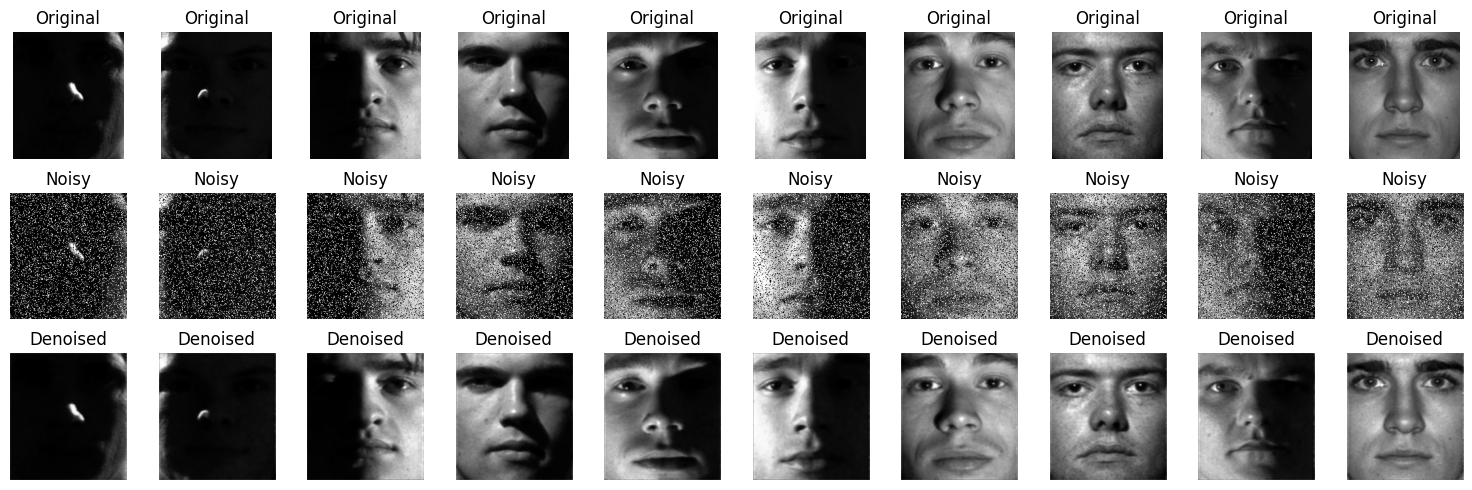

In [ ]:
num_images = 10

# Get denoised images from autoencoder
X_test_denoised = autoencoder.predict(X_test_noisy)

plt.figure(figsize=(15, 5))

for i in range(num_images):
    # Original image
    plt.subplot(3, num_images, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy image
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(X_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised image
    plt.subplot(3, num_images, i + 1 + 2*num_images)
    plt.imshow(X_test_denoised[i].squeeze(), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.tight_layout()
plt.show()

### **U-net evaluation #3**


---
This cell evaluates the performance of the denoising + classification pipeline.

1. The denoised images are resized and passed into the classification model to compute accuracy, precision, recall, and F1-score.

2. Additionally, PSNR and SSIM metrics are calculated between the denoised images and the clean ground truth, providing a measure of image quality restoration.
Together, these metrics show both how well the model restores image quality and how this restoration affects downstream classification performance.


In [ ]:
# Resize denoised images (already in X_test_denoised)
X_test_denoised_resized = np.array([resize(img, (192, 168)) for img in X_test_denoised])

# Resize ground truth (clean) test images to match
X_test_clean_resized = np.array([resize(img, (192, 168)) for img in X_test])  # Replace with your clean test set variable

test_loss, test_accuracy = model.evaluate(X_test_denoised_resized, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model.predict(X_test_denoised_resized), axis=1)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

#PSNR & SSIM Evaluation
psnr_values = []
ssim_values = []

for clean_img, denoised_img in zip(X_test_clean_resized, X_test_denoised_resized):
    # .squeeze() removes the last channel if it’s grayscale ((H, W, 1) → (H, W)).
    # If images have shape (H, W, 1), squeeze them to (H, W)
    if clean_img.ndim == 3 and clean_img.shape[-1] == 1:
        clean_img = np.squeeze(clean_img)
        denoised_img = np.squeeze(denoised_img)

    psnr_val = psnr(clean_img, denoised_img, data_range=1.0) # PSNR (Peak Signal-to-Noise Ratio): measures image reconstruction quality in dB (higher = better)
    ssim_val = ssim(clean_img, denoised_img, data_range=1.0, win_size=7, channel_axis=None) # SSIM (Structural Similarity Index): measures structural similarity (closer to 1 = more similar)

    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9081 - loss: 0.4917
Test Accuracy: 0.9190
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Precision: 0.9497, Recall: 0.9204, F1-score: 0.9239
Average PSNR: 31.31 dB
Average SSIM: 0.9570


### **U-net evaluation #4**


---
**Evaluation of Denoised Images for Classification with ROC Curve**

In this section, we evaluate a classification model using denoised images produced by a U-Net model.

1. **Binarizing Labels:**
The true labels (y_test) are binarized for the ROC curve calculation.

2. **Predicted Probabilities:**
The classification model predicts probabilities for the denoised test set (X_test_denoised_resized), which are used to calculate the ROC curve.

3. **Macro-Average ROC Curve:**
We compute the macro-average ROC curve and the AUC score. An `AUC of 0.9996` indicates excellent classification performance.

4. **Plotting the ROC Curve:**
The ROC curve visualizes the model's trade-off between True Positive Rate and False Positive Rate, with a random classifier as a baseline.

5. **Image Quality Metrics:**
`PSNR = 31.31 dB and SSIM = 0.9570` are calculated for denoised images to assess their quality. Higher PSNR and SSIM values indicate better denoising performance.


---


***These metrics show how well the denoised images improve the classification model’s accuracy and image quality.***


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


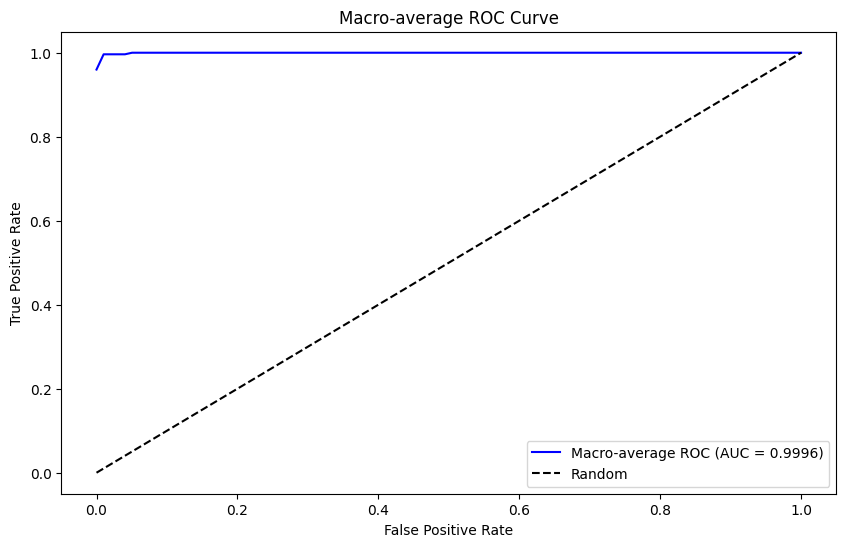

Average PSNR: 31.31 dB
Average SSIM: 0.9570


In [ ]:
# Binarize labels for ROC
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Get predicted probabilities
y_probs = model.predict(X_test_denoised_resized)

# Compute macro-average ROC
all_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)

mean_tpr /= num_classes
roc_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 6))
plt.plot(all_fpr, mean_tpr, color='b', label=f'Macro-average ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend()
plt.show()

psnr_values = []
ssim_values = []

for clean_img, denoised_img in zip(X_test_clean_resized, X_test_denoised_resized):
    # Remove extra channel if grayscale
    if clean_img.ndim == 3 and clean_img.shape[-1] == 1:
        clean_img = np.squeeze(clean_img)
        denoised_img = np.squeeze(denoised_img)

    h, w = clean_img.shape
    min_dim = min(h, w)

    win_size = min(7, min_dim if min_dim % 2 == 1 else min_dim - 1)

    psnr_val = psnr(clean_img, denoised_img, data_range=1.0)
    ssim_val = ssim(clean_img, denoised_img, data_range=1.0, win_size=win_size, channel_axis=None)

    psnr_values.append(psnr_val)
    ssim_values.append(ssim_val)

print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_values):.4f}")

# **MODEL DEPLOY**

### **Save the model**


---


### **Here we saving our model, and downloading it to use it locally or deploying for a website using Flask or FastAPI.**

In [ ]:
autoencoder.save("unet_model.h5")
files.download("unet_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>